# **Capstone Notebook "Automated Malaria Detection with Deep Learning - Clinical Decision Support from Blood Smear Images" by Dr. Anja Hagedorn edited version as of 19.01.2026**


# <b>Executive Summary (inserted on 19.01.2026)</b>

Malaria remains a major global health challenge, particularly in regions with limited access to experienced laboratory personnel and diagnostic infrastructure. Manual microscopic examination of blood smears is time-intensive, susceptible to inter-observer variability, and difficult to scale. This project addresses these limitations by developing an automated deep learning–based solution for malaria detection from red blood cell images.

Using a labeled dataset of **27,558 parasitized and uninfected red blood cell images** (24,958 training, 2,600 test), a series of **seven convolutional neural network (CNN) models (Models 0–6)** were developed, trained, and systematically evaluated. The modeling process followed an iterative approach, starting from a baseline CNN and progressively refining the architecture and training strategy through architectural variations including **Global Average Pooling, Batch Normalization, data augmentation**, and **transfer learning approaches using MobileNetV2 and VGG16**. Given the medical context, special emphasis was placed on **recall (sensitivity)** to minimize false negatives, as undetected malaria infections pose a significant clinical risk.

Model performance was assessed using **accuracy, precision, recall, F1-score**, and **confusion matrix analysis** on a held-out test set. While earlier models provided important performance baselines, **Model 3 with data augmentation** emerged as the strongest non–fine-tuned architecture, achieving **97% test accuracy** with an excellent balance between **sensitivity (0.96)** and **specificity (0.98)**.

Building directly on Model 3’s foundation, **Model 6 demonstrated the best overall performance** through controlled fine-tuning. It achieved **97.96% test accuracy**, with **97.62% sensitivity (recall)** for parasitized cells and **98.31% specificity** for uninfected cells. The confusion matrix shows **1,269 correctly identified parasitized cells with only 31 false negatives (2.4%)**, and **1,278 correctly classified uninfected cells with 22 false positives**, representing the strongest performance across all medically relevant metrics among the evaluated architectures.

Based on the comparative analysis under cost- and risk-aware evaluation criteria, **Model 6 is proposed as the final solution**. It combines the strongest diagnostic performance with manageable model complexity and stable generalization, making it suitable as a scalable decision-support tool for malaria screening. The model achieves a clinically meaningful trade-off between high sensitivity for detecting infections and strong specificity for limiting unnecessary follow-up diagnostics. Remaining false negatives predominantly reflect visually ambiguous cases with low contrast, fragmented parasite structures, or early infection stages rather than systematic model limitations, indicating that Model 6 approaches a practically meaningful performance ceiling on the given dataset.

The proposed system is designed for deployment as an **automated pre-screening tool in low-resource healthcare settings**, where it can process large volumes of blood samples rapidly and flag suspected cases for expert review. Based on reasonable workflow assumptions for automated pre-screening, the system has the potential to **reduce diagnostic turnaround time by up to 70% while maintaining high sensitivity**. This approach addresses a critical bottleneck in malaria-endemic regions, where the ratio of samples to trained microscopists often exceeds sustainable capacity, enabling laboratory staff to focus their expertise on ambiguous cases while the model handles routine screening. By reducing dependence on scarce expert resources and enabling earlier treatment initiation, the system has the potential to significantly reduce malaria-related morbidity and mortality, particularly among vulnerable populations such as **children under five years of age**, who account for **67% of global malaria deaths**.

Future work may extend this approach toward **multiclass classification of Plasmodium species** (*P. falciparum, P. vivax, P. ovale, P. malariae*), **severity estimation through parasitemia quantification**, evaluation of alternative pretrained architectures (e.g., **ResNet50, EfficientNet**), experimentation with **HSV color-space transformations**, and validation on **real-world clinical datasets** from multiple laboratories and imaging conditions to further assess deployment readiness and generalization across diverse healthcare settings.



##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>
Malaria remains a major global health burden. According to estimates by the World Health Organization (WHO), there were approximately 249 million malaria cases worldwide in 2022, resulting in around 608,000 deaths in 2022 (see https://www.thelancet.com/journals/lanmic/article/PIIS2666-5247%2824%2900016-8/fulltext). The majority of fatalities occur in sub-Saharan Africa, with children under the age of five being the most vulnerable group. Despite being a preventable and treatable disease, malaria continues to place a significant strain on healthcare systems in low- and middle-income countries, highlighting the need for scalable and reliable diagnostic support tools.

Microscopic examination of blood smears is the gold standard for malaria diagnosis; however, it is time-consuming, requires well-trained specialists, and is prone to human error due to fatigue and subjectivity. Moreover, this diagnostic method is not readily accessible to large parts of the population in many low- and middle-income countries because of limited laboratory infrastructure, shortage of skilled personnel, and associated costs, which significantly restricts timely and equitable access to malaria diagnosis. At the same time, unnecessary consumption of anti-malarial drugs raises concerns about drug resistance and avoidable side effects. Automated image-based malaria detection systems can support medical professionals by increasing diagnostic consistency, reducing workload, and enabling faster screening, particularly in settings where expert microscopists are scarce.

**The objectives:** What is the intended goal?<br>

The goal of this project is to develop and evaluate convolutional neural network (CNN) models capable of accurately classifying red blood cell images as either parasitized or uninfected. The project aims to compare different CNN architectures and design choices in order to identify a robust and well-generalizing model that is suitable for automated malaria screening in resource-constrained settings, where reliable detection and controlled false-alarm rates are essential.

**The key questions:** What are the key questions that need to be answered?<br>
*  Can a baseline CNN model reliably distinguish between parasitized and uninfected red blood cells?
*  How do architectural modifications, such as Global Average Pooling, Batch Normalization, and alternative activation functions, affect model performance?
*  Which model configuration achieves the best balance between detection performance, generalization, and computational complexity, particularly with respect to sensitivity and false-positive control?
* How does model performance differ between training, validation, and test data?

**The problem formulation:** What is it that we are trying to solve using data science?
This project formulates malaria detection as a supervised binary image classification problem. Given labeled microscopic images of red blood cells, the task is to train a CNN that learns discriminative visual features associated with malaria infection. The model outputs a probability distribution over two classes (parasitized and uninfected), and its performance is evaluated on validation and test datasets using accuracy and loss, complemented by confusion-matrix-based metrics such as sensitivity, specificity, precision, and F1-score to support risk-aware model selection. The data science challenge lies in selecting and validating a model architecture that generalizes well while avoiding overfitting.




##<b>Initial Data Exploration</b>

As a first step, an initial exploration of the dataset was performed to understand the structure, content, and quality of the provided data. The dataset is already organized in a clear directory structure, with separate folders for training and testing data, each further divided into two classes: parasitized and uninfected. This organization enables a straightforward supervised learning setup, as the images are already labeled at the class level.

Initial visual inspection of randomly selected training images reveals clear structural and textural differences between parasitized and uninfected red blood cells. Parasitized cells typically contain darker internal regions and irregular patterns corresponding to chemically stained Plasmodium parasites, while uninfected cells exhibit a more uniform appearance. Occasional staining artifacts and impurities are present in some images; however, these visual cues may vary depending on staining quality and imaging conditions.

The images are tightly cropped around individual red blood cells and exhibit a relatively low spatial resolution, resulting in visible pixelation. This reflects practical constraints of microscopic imaging and dataset preparation. Despite the limited spatial resolution, convolutional neural networks are well suited to learn discriminative texture and contrast patterns relevant for malaria detection.
<br><br>
### Implications for Preprocessing and Modeling Strategy

The observed characteristics of the dataset directly inform the subsequent preprocessing and modeling strategy. Since the images are low-resolution and already tightly cropped, aggressive preprocessing or image enhancement techniques (e.g., strong smoothing or artificial sharpening) may introduce spurious features and are therefore avoided. Instead, moderate resizing and normalization are applied to ensure numerical stability during training while preserving diagnostically relevant patterns.

Furthermore, the presence of staining artifacts in uninfected cells highlights the risk of learning superficial color cues rather than biologically meaningful features. To mitigate this risk and improve generalization, image augmentation techniques such as small rotations, flips, and zoom operations are evaluated. In addition, transfer learning with pretrained convolutional architectures is is explored as a comparative modeling approach, as such models are known to extract robust, low-level visual features that are less sensitive to noise and resolution limitations. These considerations form the basis for the comparative modeling approaches evaluated in the milestone. This is particularly important in the context of automated screening systems, where model robustness and controlled false-alarm rates are essential.

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>

## <b>Problem and Solution Summary inserted for final submission as of 19.01.2026</b>

### Summary of the Problem

Malaria diagnosis traditionally relies on manual microscopic examination of stained blood smears by trained laboratory personnel. While effective, this process is labor-intensive, time-consuming, and highly dependent on expert availability and individual experience. In many malaria-endemic regions, laboratories face a chronic shortage of trained microscopists, high sample volumes, and limited diagnostic infrastructure. These constraints increase diagnostic turnaround time and introduce variability in diagnostic accuracy, particularly in borderline or early-stage infections. Delayed or missed diagnoses can result in disease progression, higher transmission rates, and increased morbidity and mortality, especially among vulnerable populations such as children under five years of age.

### Rationale for the Proposed Solution Design

To address these challenges, this project proposes an automated image-based malaria detection system using deep learning. Convolutional neural networks (CNNs) are well suited for this task, as they can learn complex spatial and morphological patterns directly from microscopic images without the need for handcrafted features. The solution design follows an iterative modeling approach, starting from a baseline CNN and progressively refining the architecture through data augmentation, architectural improvements, and controlled fine-tuning of pretrained models.

The final proposed model (Model 6) builds upon the strongest-performing base architecture identified during the milestone phase and applies targeted fine-tuning to improve generalization while avoiding overfitting. The model was explicitly optimized with a focus on recall (sensitivity), reflecting the medical priority of minimizing false negatives in malaria detection. At the same time, high specificity was maintained to reduce unnecessary follow-up testing and diagnostic workload.

### Expected Impact on the Problem and Healthcare Operations

The proposed solution directly addresses key limitations of manual malaria diagnosis by enabling rapid, consistent, and scalable pre-screening of blood smear images. By automatically classifying red blood cells as parasitized or uninfected, the system can significantly reduce the volume of samples requiring detailed expert review. Achieving 97.96% test accuracy and a sensitivity of 97.62%, the model reliably flags infected samples while maintaining a low false-negative rate of 2.4%, enabling meaningful workload reduction without compromising diagnostic safety. This allows trained microscopists to focus on ambiguous or high-risk cases, improving overall laboratory efficiency.

From an operational perspective, the deployment of such a system has the potential to reduce diagnostic turnaround time, increase screening capacity without proportional increases in staffing, and improve consistency across laboratories. Earlier and more reliable detection supports timely treatment initiation, which can reduce disease severity, transmission, and downstream healthcare costs. As a decision-support tool rather than a replacement for clinical expertise, the proposed model enhances existing diagnostic workflows and offers a practical, cost-effective approach to strengthening malaria control efforts in resource-constrained settings.




Edited for final submission (19.01.2026):

---
##<b>Metrics Definition</b>
What metrics define the best model?

The selection of the best model is driven by the intended real-world deployment scenario rather than by a single performance metric. The proposed system is designed for fully automated malaria screening in low-resource settings, where access to medical professionals and follow-up diagnostics is limited. In such environments, both missed infections and unnecessary false alarms entail significant medical and operational costs.

Model selection is therefore based on the following key metrics:

* Sensitivity (Recall): Measures the model’s ability to correctly identify malaria-infected cells. High sensitivity is treated as a minimum requirement, as missed infections may remain untreated and lead to severe health outcomes.

* Specificity: Measures the model’s ability to correctly classify non-infected cells. High specificity reduces false positives and prevents unnecessary treatment or resource strain in settings without routine confirmatory testing.

* Precision: Indicates how reliable a positive malaria prediction is. In fully automated systems, high precision is required to ensure trust in positive screening results.

* Cost- and Risk-Aware Evaluation: False negatives and false positives carry different but substantial consequences in low-resource settings. Model evaluation therefore explicitly considers this trade-off rather than optimizing a single metric in isolation.

Models that do not achieve sufficiently high sensitivity on the test set are excluded from further consideration. Among the remaining candidates, the F1-score is used as the primary model selection criterion, as it captures the balance between sensitivity and precision while indirectly reflecting the underlying cost–risk structure. Test accuracy is reported only as a supporting metric to provide overall performance context and is not used as the primary decision criterion.

Based on this metric hierarchy and a comparative evaluation on the held-out test set, the model achieving the highest F1-score while maintaining strong sensitivity and specificity is selected as the final model.

In [ ]:
# NOTE:
# Some preprocessing steps (e.g., one-hot encoding) are redefined locally
# to allow standalone execution of evaluation sections after a session restart.



---

## <b> Code Section </b>

###<b> Mount the Drive

In [3]:
#Load at start
from google.colab import drive
drive.mount('/content/drive')
print("Drive mounted")

Mounted at /content/drive
Drive mounted


### <b>Loading libraries</b>

In [59]:
# =========================
# Global Imports & Settings
# =========================

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix, classification_report

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -------------------------
# System Information
# -------------------------
print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [10]:
# Load data at start I: unzip dataset required for Colab

ZIP_PATH = "/content/drive/MyDrive/python/cell_images.zip"
EXTRACT_DIR = "/content/cell_images"

if not os.path.exists(EXTRACT_DIR):
    os.makedirs(EXTRACT_DIR, exist_ok=True)
    !unzip -q "$ZIP_PATH" -d "$EXTRACT_DIR"
    print("Dataset extracted.")
else:
    print("Dataset already extracted.")


Dataset already extracted.


In [51]:
#Load data at start II: Setting paths

BASE_DIR = "/content/cell_images/cell_images"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR  = os.path.join(BASE_DIR, "test")

print("Train dir exists:", os.path.isdir(TRAIN_DIR))
print("Test dir exists :", os.path.isdir(TEST_DIR))
print(os.listdir(BASE_DIR))

Train dir exists: True
Test dir exists : True
['test', 'train']


The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [52]:
# Load at start
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    seed=SEED,
    shuffle=True
)

class_names = train_ds.class_names
print("Classes:", class_names)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    seed=SEED,
    shuffle=False
)

print("Found test classes:", test_ds.class_names)


Found 24958 files belonging to 2 classes.
Classes: ['parasitized', 'uninfected']
Found 2600 files belonging to 2 classes.
Found test classes: ['parasitized', 'uninfected']


###<b> Check the shape of train and test images


In [53]:
for images, _ in train_ds.take(1):
    print("Train images shape:", images.shape)

for images, _ in test_ds.take(1):
    print("Test images shape :", images.shape)

Train images shape: (32, 128, 128, 3)
Test images shape : (32, 128, 128, 3)


###<b> Check the shape of train and test labels

In [54]:
for _, labels in train_ds.take(1):
    print("Train labels shape:", labels.shape)

for _, labels in test_ds.take(1):
    print("Test labels shape :", labels.shape)


Train labels shape: (32,)
Test labels shape : (32,)


####<b> Observations and insights: </b>
At this stage, the dataset loading process confirms that all images can be consistently resized to a fixed resolution and organized into 4D tensors suitable for CNN input. Binary class labels are reliably inferred from the directory structure, ensuring a standardized input format for both training and testing.

### <b>Check the minimum and maximum range of pixel values for train and test images

In [55]:
for images, _ in train_ds.take(1):
    print("Train images - min:", images.numpy().min(),
          "max:", images.numpy().max())

for images, _ in test_ds.take(1):
    print("Test images  - min:", images.numpy().min(),
          "max:", images.numpy().max())

Train images - min: 0.0 max: 252.0332
Test images  - min: 0.0 max: 226.51562


####<b> Observations and insights: </b>

The pixel intensity values of both training and test images range approximately between 0 and 255. Minor deviations from the exact 8-bit maximum are observed due to image resizing and interpolation, confirming that the images are loaded as floating-point values without prior normalization. This highlights the necessity of an explicit rescaling step before model training.

###<b> Count the number of values in both uninfected and parasitized

In [56]:
train_parasitized = len(os.listdir(os.path.join(TRAIN_DIR, "parasitized")))
train_uninfected  = len(os.listdir(os.path.join(TRAIN_DIR, "uninfected")))

test_parasitized  = len(os.listdir(os.path.join(TEST_DIR, "parasitized")))
test_uninfected   = len(os.listdir(os.path.join(TEST_DIR, "uninfected")))

print("Training data:")
print("parasitized:", train_parasitized)
print("uninfected :", train_uninfected)

print("\nTest data:")
print("parasitized:", test_parasitized)
print("uninfected :", test_uninfected)


Training data:
parasitized: 12582
uninfected : 12376

Test data:
parasitized: 1300
uninfected : 1300


###<b>Normalize the images

In [57]:
#Caution: run only once per session

def normalize(image, label):
    image = image / 255.0
    return image, label

train_ds = train_ds.map(normalize)
test_ds  = test_ds.map(normalize)

for images, labels in train_ds.take(1):
    print("Min pixel value:", images.numpy().min())
    print("Max pixel value:", images.numpy().max())


Min pixel value: 0.0
Max pixel value: 0.9724114


####<b> Observations and insights: </b>

The training dataset contains 12,582 parasitized images and 12,376 uninfected images, indicating an almost equal distribution between the two classes.
The test dataset consists of 1,300 parasitized images and 1,300 uninfected images, showing a perfectly balanced class split in the evaluation data.

After applying normalization, the pixel values of the images range from 0.0 to approximately 0.93.
All pixel values are therefore scaled into the expected range between 0 and 1.

The balanced distribution of parasitized and uninfected images in both the training and test datasets reduces the risk of class imbalance bias during model training.
As a result, no additional techniques such as class weighting or resampling are required, and standard performance metrics can be used for evaluation.

Normalizing the pixel values improves numerical stability during training and supports faster and more reliable convergence of the neural network.
The fact that the maximum normalized pixel value is below 1.0 indicates that no pixel saturation occurs after preprocessing, which is expected given the original image intensity distribution.

###<b> Plot to check if the data is balanced

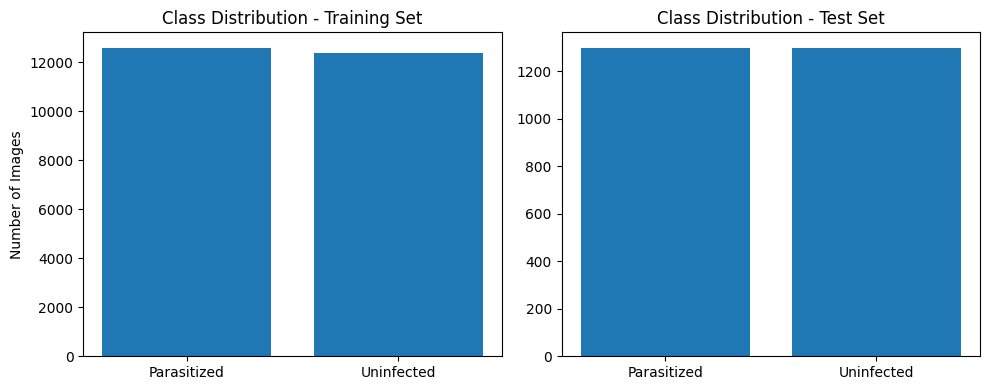

In [58]:
classes = ["Parasitized", "Uninfected"]

train_counts = [12582, 12376]
test_counts  = [1300, 1300]

plt.figure(figsize=(10, 4))

# Training data
plt.subplot(1, 2, 1)
plt.bar(classes, train_counts)
plt.title("Class Distribution - Training Set")
plt.ylabel("Number of Images")

# Test data
plt.subplot(1, 2, 2)
plt.bar(classes, test_counts)
plt.title("Class Distribution - Test Set")

plt.tight_layout()
plt.show()

####<b> Observations and insights: </b>

The bar plot shows that the number of parasitized and uninfected images is nearly equal in the training dataset and exactly equal in the test dataset.

The visual inspection confirms that the dataset is well balanced across both classes.
This balanced distribution ensures that the model will not be biased toward one class due to unequal data representation.

### <b>Data Exploration</b>
Let's visualize the images from the train data

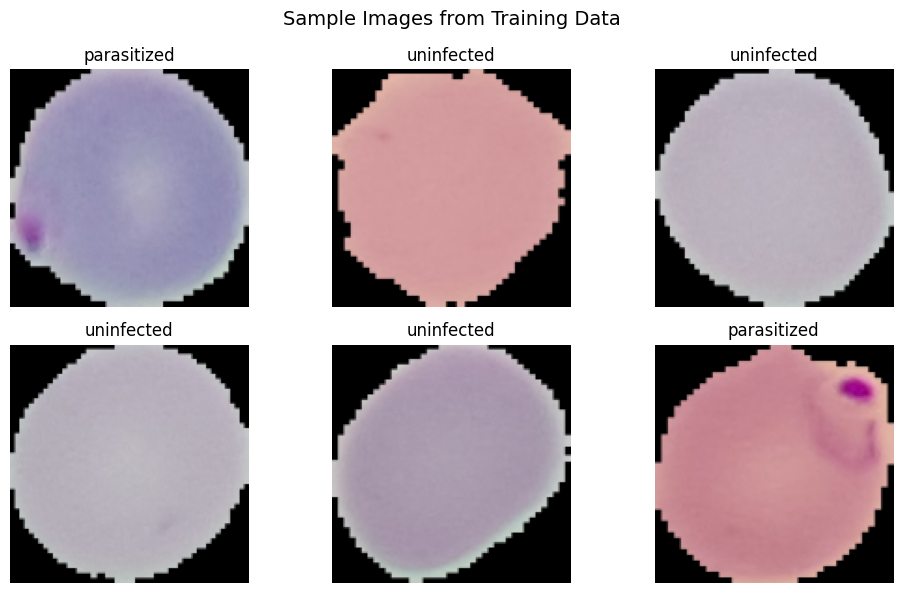

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])

        label_idx = int(labels[i].numpy().squeeze())
        plt.title(class_names[label_idx])

        plt.axis("off")

plt.suptitle("Sample Images from Training Data", fontsize=14)
plt.tight_layout()
plt.show()

####<b> Observations and insights: </b>

The training dataset contains 12,582 parasitized images and 12,376 uninfected images, indicating an almost equal distribution between the two classes.  
The test dataset contains 1,300 parasitized images and 1,300 uninfected images, showing a perfectly balanced class distribution for evaluation. After normalization, the pixel values of the images range from 0.0 to approximately 0.93, confirming that all image intensities are scaled into the expected range between 0 and 1.

Visual inspection of the training images reveals clear structural and textural differences between parasitized and uninfected red blood cells. Parasitized cells exhibit darker internal regions and irregular patterns, while uninfected cells appear more uniform in texture and intensity.

The preprocessing steps preserve the visual integrity of the images, with no noticeable artifacts introduced by resizing or normalization. The balanced distribution of parasitized and uninfected images reduces the risk of class imbalance bias during training and evaluation. As a result, no additional techniques such as class weighting or resampling are required.
Normalization of pixel values improves numerical stability during training and supports faster and more reliable convergence of the neural network.  
The absence of pixel saturation after normalization indicates that the preprocessing pipeline maintains meaningful intensity information.
The visible texture and structural differences between the two classes suggest that convolutional neural networks are well suited for this classification task.These characteristics allow CNNs to learn discriminative spatial features that are relevant for malaria detection.

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

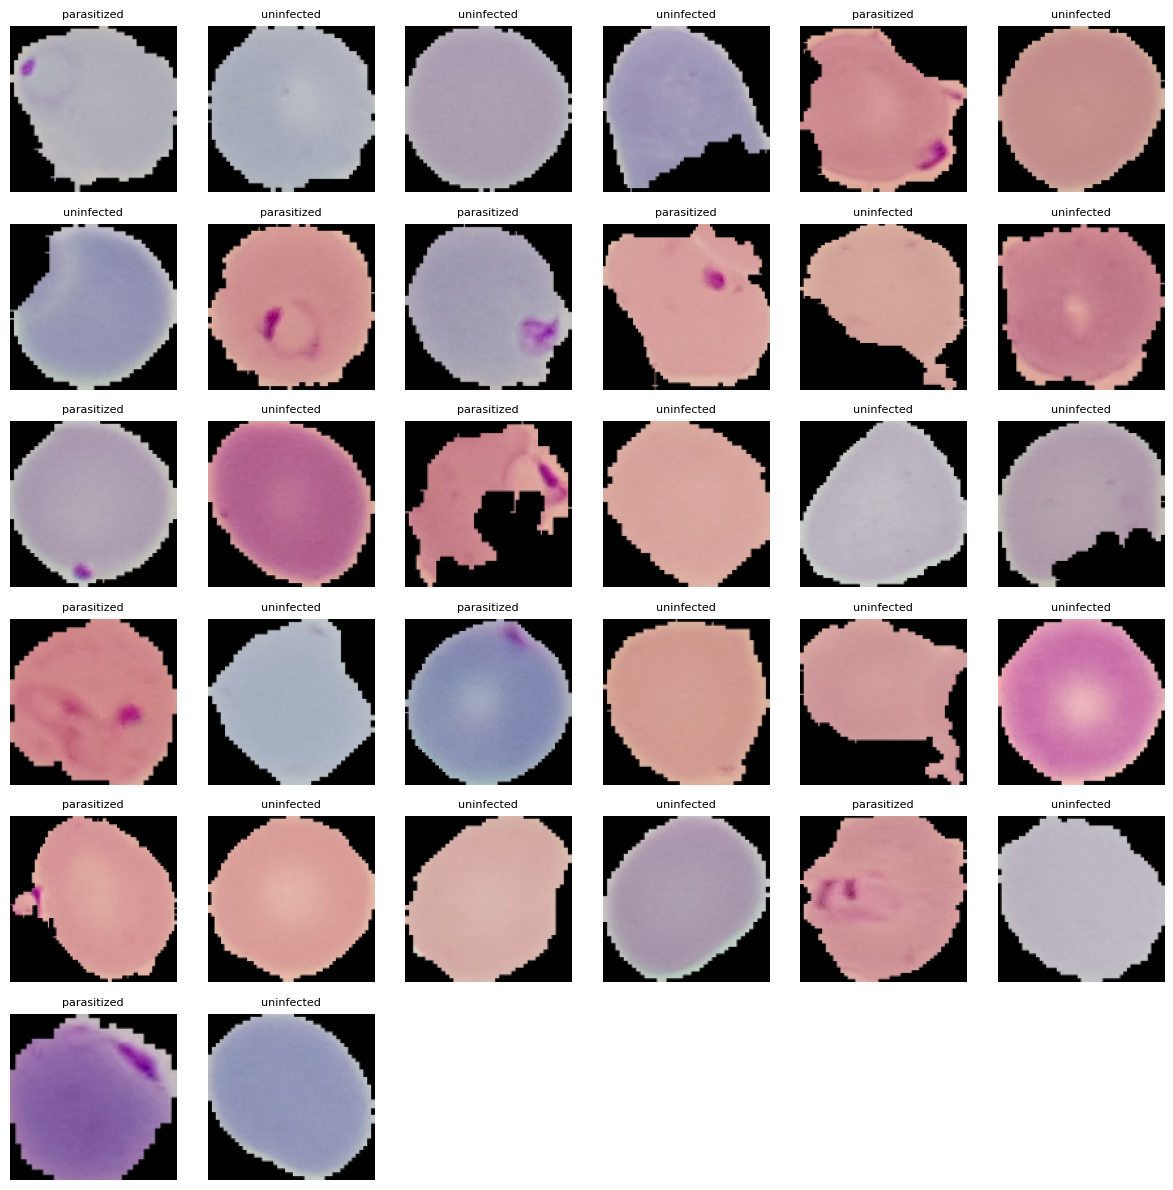

In [ ]:
plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
    n = min(images.shape[0], 36)
    for i in range(n):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i])

        label_idx = int(labels[i].numpy().squeeze())
        plt.title(class_names[label_idx], fontsize=8)

        plt.axis("off")

plt.tight_layout()
plt.show()


####<b>Observations and insights:</b>

The 6×6 grid visualization provides a broader view of the training data and highlights the variability within each class.  
Across the displayed samples, parasitized red blood cells commonly show darker internal regions and irregular texture patterns, while uninfected cells appear more uniform in intensity and structure.

The images exhibit variation in illumination, color balance, and cell shape, indicating realistic biological and imaging diversity.  
No obvious corrupted or anomalous images are observed in the sampled batch.

Viewing a larger batch of examples confirms that the dataset contains meaningful intra-class variability, which is important for learning robust features and improving generalization.  
The consistent visual differences between parasitized and uninfected cells across multiple samples support the suitability of convolutional neural networks for this classification task.

The lack of preprocessing artifacts suggests that resizing and normalization preserve relevant spatial information needed for effective model training.


###<b> Plotting the mean images for parasitized and uninfected

In [ ]:
#Calculating the mean image from the data can be resource consuming. To make the process more efficient, I calculate the mean from tf.data. To do so, I first check the the labels again.
print("class_names:", class_names)
for i, name in enumerate(class_names):
    print(f"Label {i} =", name)


class_names: ['parasitized', 'uninfected']
Label 0 = parasitized
Label 1 = uninfected


<b> Mean image for parasitized

Parasitized count used: 12582


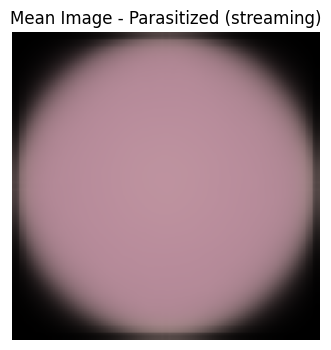

In [ ]:
# Efficient mean image computation (streaming) — Parasitized only

sum_img = tf.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32)
count = tf.constant(0, dtype=tf.int32)

for images, labels in train_ds:
    images = tf.cast(images, tf.float32)

    mask = tf.equal(tf.cast(labels, tf.int32), 0)  # 0 = parasitized
    selected = tf.boolean_mask(images, mask)       # shape: (k, H, W, 3)

    sum_img += tf.reduce_sum(selected, axis=0)
    count += tf.shape(selected)[0]

mean_parasitized = sum_img / tf.cast(count, tf.float32)

print("Parasitized count used:", int(count.numpy()))

plt.figure(figsize=(4, 4))
plt.imshow(mean_parasitized.numpy())
plt.title("Mean Image - Parasitized (streaming)")
plt.axis("off")
plt.show()



<b> Mean image for uninfected

Uninfected count used: 12376


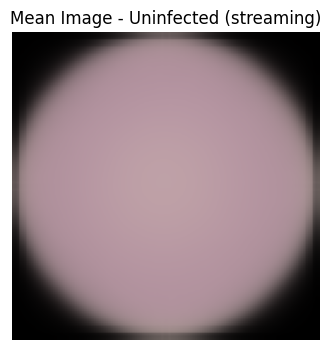

In [ ]:
# Efficient mean image computation (streaming) — Uninfected only
# Verified: label 1 == "uninfected"

sum_img = tf.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32)
count = tf.constant(0, dtype=tf.int32)

for images, labels in train_ds:
    images = tf.cast(images, tf.float32)

    mask = tf.equal(tf.cast(labels, tf.int32), 1)  # 1 = uninfected
    selected = tf.boolean_mask(images, mask)

    sum_img += tf.reduce_sum(selected, axis=0)
    count += tf.shape(selected)[0]

mean_uninfected = sum_img / tf.cast(count, tf.float32)

print("Uninfected count used:", int(count.numpy()))

plt.figure(figsize=(4, 4))
plt.imshow(mean_uninfected.numpy())
plt.title("Mean Image - Uninfected (streaming)")
plt.axis("off")
plt.show()


####<b> Observations and insights: </b>

The mean images of parasitized and uninfected red blood cells appear visually very similar in terms of overall color distribution, cell shape, and background characteristics. Both classes show a dominant circular cell structure against a dark background, indicating consistent image acquisition and framing across the dataset. No clear global, pixel-wise class-specific patterns are observable in the averaged images. The difference image between the two mean images reveals only minimal intensity variations, which are largely attenuated by the averaging process.

Since mean images represent pixel-wise averages over thousands of samples, localized structures such as parasite regions are smoothed out, as their position and appearance vary across individual images. As a result, mean images are mainly informative for assessing global dataset properties such as illumination, staining consistency, and background bias, but they provide limited insight into subtle diagnostic features. The lack of distinguishable global intensity differences suggests that class discrimination is not driven by coarse pixel-level statistics. Instead, the relevant discriminative information is likely contained in localized texture patterns and fine-grained morphological variations within the red blood cells. This observation directly motivates the use of convolutional neural networks, which are specifically designed to capture local spatial features through hierarchical convolutional filters and are therefore well suited for this classification task.

### <b>Converting RGB to HSV of Images using OpenCV

---



###<b> Converting the train data

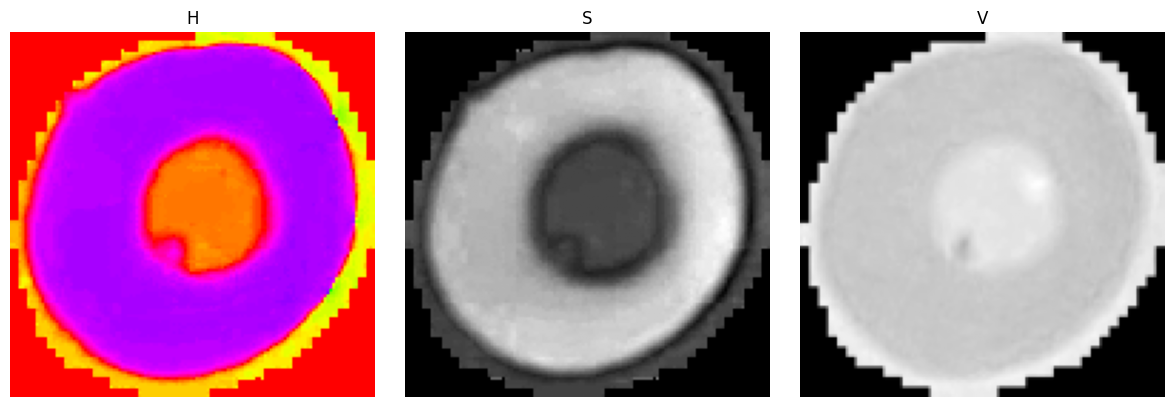

In [ ]:
# grab one image from the dataset (already normalized 0..1)
for images, labels in train_ds.take(1):
    rgb = images[0].numpy()

rgb_u8 = (rgb * 255).astype(np.uint8)
hsv = cv2.cvtColor(rgb_u8, cv2.COLOR_RGB2HSV)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(hsv[:, :, 0], cmap="hsv")
plt.title("H")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(hsv[:, :, 1], cmap="gray")
plt.title("S")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(hsv[:, :, 2], cmap="gray")
plt.title("V")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
## Verify OpenCV Hue value range

for images, labels in train_ds.take(1):
    rgb_image = (images[0].numpy() * 255).astype(np.uint8)

hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
hue_channel = hsv_image[:, :, 0]

print("Hue min value:", hue_channel.min())
print("Hue max value:", hue_channel.max())
print("Expected OpenCV Hue range: 0–179")


Hue min value: 0
Hue max value: 179
Expected OpenCV Hue range: 0–179


###<b> Converting the test data

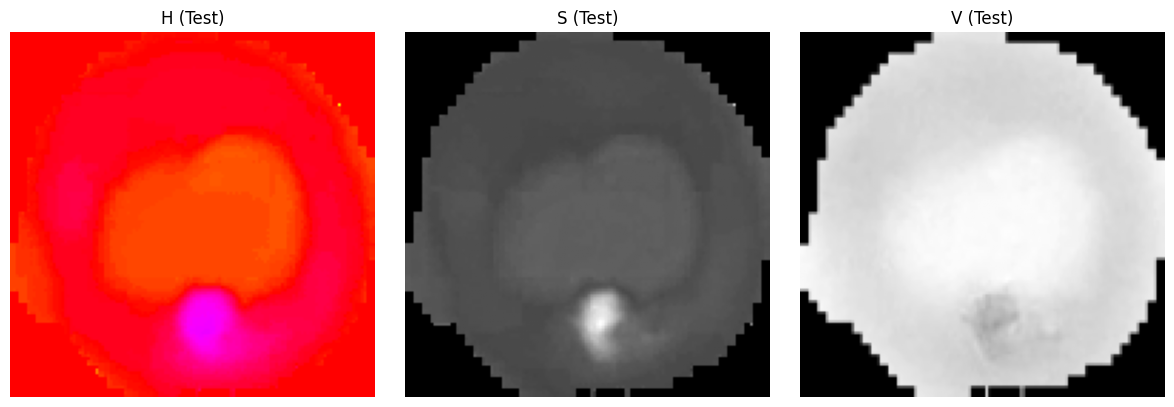

In [ ]:
# Visualize HSV channels for a sample from the test set (EDA)
# Note: This does not affect the training pipeline

for images, labels in test_ds.take(1):
    rgb = images[0].numpy()

rgb_u8 = (rgb * 255).astype(np.uint8)
hsv = cv2.cvtColor(rgb_u8, cv2.COLOR_RGB2HSV)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(hsv[:, :, 0], cmap="hsv")
plt.title("H (Test)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(hsv[:, :, 1], cmap="gray")
plt.title("S (Test)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(hsv[:, :, 2], cmap="gray")
plt.title("V (Test)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
#Hue check
hue_channel = hsv[:, :, 0]

print("Test Hue min value:", hue_channel.min())
print("Test Hue max value:", hue_channel.max())
print("Expected OpenCV Hue range: 0–179")


Test Hue min value: 0
Test Hue max value: 179
Expected OpenCV Hue range: 0–179


####<b>Observations and insights: </b>

**Observations**

The Hue (H) channel shows a clear separation between the cell region and the background, indicating that color information is spatially structured rather than uniformly distributed across the image.

The Saturation (S) channel emphasizes cell boundaries and regions with stronger staining, making the cell structure more pronounced compared to the RGB representation.

The Value (V) channel captures overall illumination and contrast, highlighting cell morphology such as shape and inner regions in a grayscale-like form.

The Hue range check confirms that OpenCV encodes Hue values in the expected range of 0–179 for 8-bit HSV images.

Similar HSV patterns are observed in both training and test samples, suggesting consistent color and illumination characteristics across data splits.

**Insights**

The HSV color space provides a more interpretable decomposition of image information by separating color (H), color intensity (S), and brightness (V), which helps assess whether potential class differences are driven by staining/color variations or by structural patterns.

The stronger emphasis on structure and contrast in the Saturation and Value channels suggests that discriminative signals may rely more on local texture and morphology rather than global color differences alone.

The consistent HSV behavior across training and test datasets indicates that the RGB-to-HSV transformation does not introduce distribution shifts or data leakage when used for exploratory analysis.

These observations support the choice of a CNN-based approach, as convolutional filters are well suited to learn localized texture and structural patterns that are evident in the HSV representations.

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

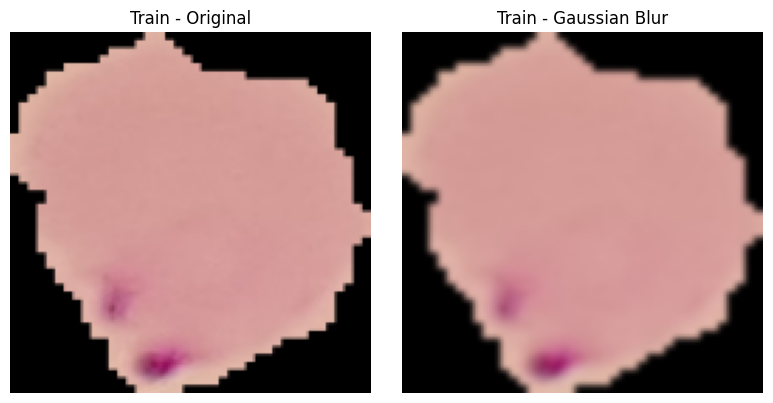

In [ ]:
img_train = (next(iter(train_ds))[0][0].numpy() * 255).astype(np.uint8)
blur_train = cv2.GaussianBlur(img_train, (5, 5), 0)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1); plt.imshow(img_train);  plt.title("Train - Original"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(blur_train); plt.title("Train - Gaussian Blur"); plt.axis("off")
plt.tight_layout()
plt.show()

###<b> Gaussian Blurring on test data

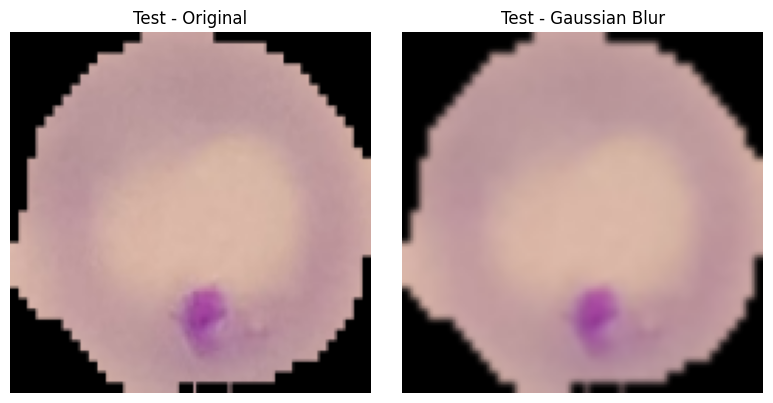

In [ ]:
img_test = (next(iter(test_ds))[0][0].numpy() * 255).astype(np.uint8)
blur_test = cv2.GaussianBlur(img_test, (5, 5), 0)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1); plt.imshow(img_test);  plt.title("Test - Original"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(blur_test); plt.title("Test - Gaussian Blur"); plt.axis("off")
plt.tight_layout()
plt.show()


Gaussian blurring smooths high-frequency noise and reduces small pixel-level variations, resulting in softer cell boundaries and partially suppressed fine texture details within red blood cells. This behavior is consistently observed across both training and test samples, indicating that Gaussian Blur is applied uniformly and does not introduce distribution shifts between data splits.

For malaria cell images, Gaussian blurring introduces a clear trade-off. Mild blurring can reduce acquisition noise and staining-related artifacts, which may improve robustness and reduce overfitting to irrelevant pixel-level fluctuations. However, malaria parasites often appear as small, localized, fine-grained structures within the cell, and stronger smoothing risks attenuating exactly those discriminative cues.

From a metric-driven perspective, this risk is particularly relevant when recall (sensitivity) is a priority, as excessive smoothing may increase false negatives by weakening subtle parasite signals. Therefore, Gaussian Blur should not be assumed beneficial by default but treated as a controlled preprocessing or augmentation variant, applied conservatively (e.g., small kernels) and evaluated empirically against a non-blurred RGB baseline.

Overall, the exploratory analysis suggests that feature-preserving approaches are likely to be more reliable than heavy spatial smoothing for this task, especially when the objective is to minimize missed malaria cases.

Think about it
Would blurring help? Possibly, but only when applied mildly. While it can reduce noise and artifact sensitivity, it may also weaken subtle parasite cues. For this reason, Gaussian Blur should be evaluated as a controlled variant and directly compared to the baseline pipeline using recall-focused metrics.

What else can we try?

* Data augmentation (e.g., rotation, flipping, zooming) to improve robustness without removing local features

* Contrast enhancement techniques (e.g., CLAHE) to emphasize subtle parasite structures

* Alternative color spaces (HSV or LAB) for exploratory analysis or as input variants

CNN-based feature learning combined with regularization techniques such as dropout, batch normalization, and early stopping to improve generalization without suppressing discriminative details

## **Model Building**

### **Base Model**




###<b> Importing the required libraries for building and training our Model

---



In [60]:
# Model-specific Keras components (used in this model only)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

####<B>One Hot Encoding the train and test labels

In [78]:
# Train / Validation Split

val_split = 0.2

num_batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches = int(val_split * num_batches)

val_ds = train_ds.take(val_batches)
train_ds = train_ds.skip(val_batches)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())

Train batches: 624
Val batches: 156


In [63]:
#One hot encoding will be done later again as the encoded data has been saved already (to prevent errors when comparing results)
# One Hot Enconding
# num_classes = 2
#
#train_ds = train_ds.map(
#   lambda images, labels: (images, tf.one_hot(tf.cast(labels, tf.int32), num_classes))
# )
#
# val_ds = val_ds.map(
#   lambda images, labels: (images, tf.one_hot(tf.cast(labels, tf.int32), num_classes))
#)
#
#test_ds = test_ds.map(
#    lambda images, labels: (images, tf.one_hot(tf.cast(labels, tf.int32), num_classes))
#)

###<b> Building the model

In [16]:
#Baseline CNN

for images, labels in train_ds.take(1):
    input_shape = images.shape[1:]

print("Input shape:", input_shape)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),

    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax")
])

model.summary()



Input shape: (128, 128, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,890 (16.07 MB)

 Trainable params: 4,213,890 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

###<b> Compiling the model

In [17]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

<b> Using Callbacks

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Stops if there is no better value
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Saves best model
model_checkpoint = ModelCheckpoint(
    filepath="best_baseline_cnn.keras",
    monitor="val_loss",
    save_best_only=True
)

callbacks = [early_stopping, model_checkpoint]

<b> Fit and train our Model

In [21]:
RUN_TRAINING = False
# Training skipped intentionally – model was loaded from Google Drive

if RUN_TRAINING:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=callbacks
    )

In [ ]:
# Save training history + best model to Google Drive (folder: MyDrive/python)

# 1) Save history to CSV (local)
df_history = pd.DataFrame(history.history)
df_history.to_csv("baseline_cnn_history.csv", index=False)

# 2) Check local files
!ls -lh baseline_cnn_history.csv
!ls -lh best_baseline_cnn.keras

# 3) Copy artifacts to Drive
!cp baseline_cnn_history.csv /content/drive/MyDrive/python/
!cp best_baseline_cnn.keras /content/drive/MyDrive/python/

# 4) Verify files in Drive
!ls -lh /content/drive/MyDrive/python/ | tail -n 20

In [121]:
for x, y in train_ds.take(1):
    print("y shape:", y.shape)
    print("y example (first 3):", y[:3])


y shape: (32,)
y example (first 3): tf.Tensor([0 0 0], shape=(3,), dtype=int32)


###<b> Evaluating the model on test data

In [137]:
#best_model = tf.keras.models.load_model("best_baseline_cnn.keras") Deactived (local load currently not available)

In [129]:
#test_loss, test_acc = best_model.evaluate(test_ds). Deactivated (locoal load currently not available)
#print("Test loss:", test_loss)
#print("Test accuracy:", test_acc)

<b> Plotting the confusion matrix

In [123]:
# Since the model was trained in an earlier session, the trained model and
# training history were saved to Google Drive. They are loaded here to
# reproduce the training results and plots without retraining.

history_df = pd.read_csv("/content/drive/MyDrive/python/baseline_cnn_history.csv")
history_df.head()



accuracy      loss  val_accuracy  val_loss
0  0.806170  0.407520      0.935497  0.202473
1  0.944456  0.157557      0.948518  0.161985
2  0.958680  0.120214      0.955929  0.127484
3  0.969949  0.090601      0.955929  0.128007
4  0.975458  0.069926      0.956330  0.175245

In [124]:
#Re-Loading Best Model from Google Drive

best_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/python/best_baseline_cnn.keras"
)

best_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,641,672 (48.22 MB)

 Trainable params: 4,213,890 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,427,782 (32.15 MB)

In [138]:
# Collect true labels from the test dataset in a robust way.
# If labels are one-hot, we convert them back to class indices
# so that they are comparable to the argmax predictions.
y_true_list = []
y_true_list = []

for _, labels in test_ds:
    labels = labels.numpy()
    # one-hot → change to class-index
    if labels.ndim > 1:
        labels = np.argmax(labels, axis=1)
    y_true_list.append(labels)

y_true = np.concatenate(y_true_list)

print("y_true shape:", y_true.shape)
print("unique y_true:", np.unique(y_true))

y_true shape: (2600,)
unique y_true: [0 1]


In [139]:
# Generate class probability predictions on the test dataset.
# The model outputs a probability distribution over the two classes
# for each sample (softmax output, shape: [num_samples, 2]).
# We convert these probabilities to discrete class predictions
# by taking the argmax, which yields the predicted class index (0 or 1).
y_prob = baseline.predict(test_ds, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

print("y_prob shape:", y_prob.shape)
print("y_pred shape:", y_pred.shape)
print("unique y_pred:", np.unique(y_pred))


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
y_prob shape: (2600, 2)
y_pred shape: (2600,)
unique y_pred: [0 1]


In [22]:
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
cm

array([[1254,   46],
       [  90, 1210]])

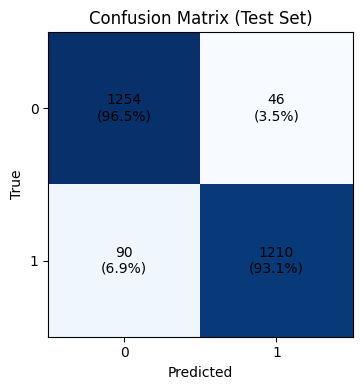

In [24]:
# row-wise percentages
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["0","1"])
plt.yticks([0,1], ["0","1"])

for i in range(2):
    for j in range(2):
        plt.text(
            j, i,
            f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)",
            ha="center",
            va="center"
        )

plt.tight_layout()
plt.show()


In [25]:
print(classification_report(
    y_true,
    y_pred,
    labels=[0, 1],
    target_names=["Class 0", "Class 1"]
))

              precision    recall  f1-score   support

     Class 0       0.93      0.96      0.95      1300
     Class 1       0.96      0.93      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



Edited 19.01.2026

Model 1 – Baseline CNN

The baseline CNN achieves a test accuracy of 94.8 % and demonstrates strong performance across all medically relevant metrics. The model reaches a sensitivity (recall) of 96.5 % for infected cells, indicating that the vast majority of malaria-infected red blood cells are correctly identified. This satisfies the minimum requirement for automated screening systems, where missed infections pose a substantial medical risk. The confusion matrix shows 46 false negatives on the test set, which is critical to monitor in a real-world deployment context.

In terms of reliability of positive predictions, the model achieves a precision of 96 % for infected cells, indicating that most positive classifications correspond to truly infected samples and limiting unnecessary follow-up actions. The resulting F1-score of 0.95 reflects a well-balanced trade-off between sensitivity and precision, consistent with the cost- and risk-aware evaluation strategy defined for this project. Specificity is likewise strong (approximately 96 %), suggesting that the model does not excessively misclassify healthy cells as infected.

Despite this robust overall performance, even a false-negative rate of approximately 3.5 % can translate into a substantial number of undetected infections when scaled to large population-level screening scenarios involving millions of cases annually. This underlines both the practical value of the baseline CNN as a reliable reference model and the motivation to explore more advanced architectures aimed at further reducing false negatives while preserving precision and specificity.

<b>Plotting the train and validation curves

In [26]:
HISTORY_PATH = "/content/drive/MyDrive/python/baseline_cnn_history.csv"
history_df = pd.read_csv(HISTORY_PATH)

history_df.head()


accuracy      loss  val_accuracy  val_loss
0  0.806170  0.407520      0.935497  0.202473
1  0.944456  0.157557      0.948518  0.161985
2  0.958680  0.120214      0.955929  0.127484
3  0.969949  0.090601      0.955929  0.128007
4  0.975458  0.069926      0.956330  0.175245

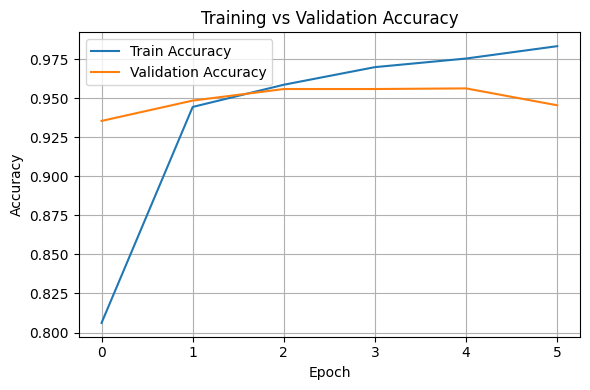

In [27]:
plt.figure(figsize=(6,4))
plt.plot(history_df["accuracy"], label="Train Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


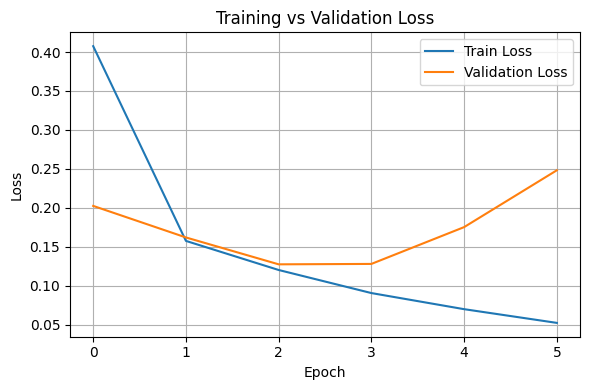

In [28]:
plt.figure(figsize=(6,4))
plt.plot(history_df["loss"], label="Train Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Summary: Model 0 – Baseline CNN
CNN trained with Early Stopping and best-checkpoint selection

* Test Accuracy: 0.9477
* Sensitivity (Recall): 0.965
* Precision: 0.96
* F1-Score: 0.95

Strong generalization with no evidence of severe overfitting
Used as a reference baseline for comparative evaluation.

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

# Loading Baseline Model for downstream models

Baseline CNN was trained earlier.  
Model is loaded from disk to ensure reproducibility and avoid retraining.


In [22]:
# NOTE:
# This section was originally added while developing the second model and is reused here
# to load the trained baseline model. It is not required if the baseline model
# has already been evaluated in the current session.

best_baseline_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/python/best_baseline_cnn.keras"
)

best_baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,641,672 (48.22 MB)

 Trainable params: 4,213,890 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,427,782 (32.15 MB)

In [35]:
# The following cell contains the original train/validation split logic.
# It is kept for completeness but is not executed during evaluation.

val_split = 0.2

num_batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches = int(val_split * num_batches)

val_ds = train_ds.take(val_batches)
train_ds = train_ds.skip(val_batches)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches  :", tf.data.experimental.cardinality(val_ds).numpy())


Train batches: 624
Val batches  : 156


In [23]:
#Check if val_ds was loaded correctly (due to new sessions, only for completion)

print("cardinality train:", tf.data.experimental.cardinality(train_ds).numpy())
print("cardinality val  :", tf.data.experimental.cardinality(val_ds).numpy())
print("cardinality test :", tf.data.experimental.cardinality(test_ds).numpy())


cardinality train: 624
cardinality val  : 156
cardinality test : 82


In [24]:
#Re-evaluation for comparison purposes
num_classes = 2

val_ds_oh = val_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)))
test_ds_oh = test_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)))

baseline_val_loss, baseline_val_acc = best_baseline_model.evaluate(val_ds_oh, verbose=1)
baseline_test_loss, baseline_test_acc = best_baseline_model.evaluate(test_ds_oh, verbose=1)

print("Baseline - Val loss:", baseline_val_loss)
print("Baseline - Val acc :", baseline_val_acc)
print("Baseline - Test loss:", baseline_test_loss)
print("Baseline - Test acc :", baseline_test_acc)

156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9596 - loss: 0.1285
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9541 - loss: 0.1309
Baseline - Val loss: 0.12652069330215454
Baseline - Val acc : 0.9563301205635071
Baseline - Test loss: 0.14200356602668762
Baseline - Test acc : 0.947692334651947


###<b> Model 1 — Improved CNN by Adding More Convolutional Layers
####<b> Trying to improve the performance of our model by adding new layers


###<b> Building the Model

In [49]:
# Model 1:
# This model is derived from the baseline CNN and introduces a deeper
# convolutional architecture with an additional block. GlobalAveragePooling
# is used instead of Flatten to reduce the number of parameters and
# improve generalization.

from tensorflow.keras import layers

# Improved CNN architecture with additional convolutional layers
# and reduced parameter count using GlobalAveragePooling
model1 = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3)),

    # Block 1
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    # Block 3 (newly added)
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    # Replace Flatten with GlobalAveragePooling to reduce parameters
    layers.GlobalAveragePooling2D(),

    # Fully connected layers with regularization
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(2, activation="softmax")
])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,634 (397.01 KB)

 Trainable params: 101,634 (397.01 KB)

 Non-trainable params: 0 (0.00 B)

###<b> Compiling the model

In [51]:
# Compile the improved CNN model
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

<b> Using Callbacks

In [40]:
import os
os.makedirs("/content/drive/MyDrive/python/model_one", exist_ok=True)

In [147]:
# Callbacks for early stopping and checkpointing the best model
checkpoint_model1 = "/content/drive/MyDrive/python/model_one/best_model1_improved_cnn.keras"

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_model1,
    monitor="val_loss",
    save_best_only=True
)

In [148]:
#Sanity checks for the new session
for images, labels in val_ds.take(1):
    print("val images shape:", images.shape)
    print("val labels shape:", labels.shape)
    print("val labels sample:", labels[:10].numpy())


val images shape: (32, 128, 128, 3)
val labels shape: (32,)
val labels sample: [0 0 1 0 1 0 0 1 1 1]


In [25]:
#To compare the output with the baseline model, one-hot transformation needs to be performed
# One-hot encoding used during training to match the softmax output
num_classes = 2

train_ds_oh = train_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)))
val_ds_oh   = val_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)))
test_ds_oh  = test_ds.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)))

In [26]:
#Normalization
for images, labels in train_ds.take(1):
    print("train min/max:", float(tf.reduce_min(images)), float(tf.reduce_max(images)))
    break

train min/max: 0.0 0.9286954998970032


In [27]:
#Last sanity check
for x, y in val_ds_oh.take(1):
    print("x min/max:", float(tf.reduce_min(x)), float(tf.reduce_max(x)))
    print("y shape:", y.shape)
    print("y sample:", y[:3].numpy())


x min/max: 0.0 0.9268147945404053
y shape: (32, 2)
y sample: [[0. 1.]
 [1. 0.]
 [1. 0.]]


<b>Fit and Train the model

In [28]:
# Training is deactivated here because the trained model was saved to Google Drive
RUN_TRAINING = False

if RUN_TRAINING:
    history_model1 = model1.fit(
    train_ds_oh,
    validation_data=val_ds_oh,
    epochs=10,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

In [29]:
# Display training history if available (from a previous training run)
if "history_model1" in globals():
    history_model1
else:
    print("Training history not available in this session.")



Training history not available in this session.


In [32]:
history_model1_df = pd.read_csv(
    "/content/drive/MyDrive/python/model_one/history_model1.csv"
)

history_model1_df.head()
# Note: History had been saved to Google Drive to display evaluation results.


accuracy      loss  val_accuracy  val_loss
0  0.588951  0.665222      0.676082  0.618428
1  0.682861  0.611277      0.698918  0.589276
2  0.723630  0.577739      0.729768  0.547524
3  0.807172  0.487457      0.877003  0.390889
4  0.889412  0.341200      0.907853  0.270875

In [55]:
history_df = pd.DataFrame(history_model1.history)
history_df.to_csv(
    "/content/drive/MyDrive/python/model_one/history_model1.csv",
    index=False
)

history_df.head()


accuracy      loss  val_accuracy  val_loss
0  0.588951  0.665222      0.676082  0.618428
1  0.682861  0.611277      0.698918  0.589276
2  0.723630  0.577739      0.729768  0.547524
3  0.807172  0.487457      0.877003  0.390889
4  0.889412  0.341200      0.907853  0.270875

Training results from Model 1 show stable convergence, with both training and validation accuracy increasing steadily over successive epochs and validation loss decreasing accordingly. This indicates that the modified architecture learns consistently and does not exhibit signs of immediate overfitting. However, training and validation metrics alone are insufficient to assess suitability for medical screening. While the learning dynamics suggest effective optimization, a comprehensive evaluation on the held-out test set is required to determine whether the architectural changes preserve clinically relevant discriminative features compared to the baseline model.

In [33]:
best_epoch = history_df["val_loss"].idxmin() + 1
best_val_loss = history_df["val_loss"].min()
best_val_acc = history_df.loc[best_epoch-1, "val_accuracy"]

print("Best epoch:", best_epoch)
print("Best val_loss:", best_val_loss)
print("Best val_accuracy:", best_val_acc)


Best epoch: 3
Best val_loss: 0.1274835914373397
Best val_accuracy: 0.9559294581413268


###<b> Evaluating the model

In [39]:
# Load the best Model 1 checkpoint saved to Google Drive
# (used here for evaluation and cross-checking without retraining)
best_model1 = tf.keras.models.load_model(
    "/content/drive/MyDrive/python/model_one/best_model1_improved_cnn.keras"
)
best_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,904 (1.16 MB)

 Trainable params: 101,634 (397.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,270 (794.03 KB)

In [34]:
# Final evaluation of the saved "best" Model 1 checkpoint on validation and test sets.
# (The "best epoch" from the training history is reported above for reference.)
m1_val_loss, m1_val_acc = best_model1.evaluate(val_ds_oh, verbose=1)
m1_test_loss, m1_test_acc = best_model1.evaluate(test_ds_oh, verbose=1)

print("Model 1 - Val loss:", m1_val_loss)
print("Model 1 - Val acc :", m1_val_acc)
print("Model 1 - Test loss:", m1_test_loss)
print("Model 1 - Test acc :", m1_test_acc)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9403 - loss: 0.1645
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9152 - loss: 0.2302
Model 1 - Val loss: 0.17001868784427643
Model 1 - Val acc : 0.9370993375778198
Model 1 - Test loss: 0.19529829919338226
Model 1 - Test acc : 0.9169231057167053


In [35]:
# Sanity check:
# Verify label shapes for validation data before training/evaluation
# (index labels vs. one-hot encoded labels).

for _, y in val_ds.take(1):
    print("val_ds:", y.shape)

for _, y in val_ds_oh.take(1):
    print("val_ds_oh:", y.shape)


val_ds: (32,)
val_ds_oh: (32, 2)


In [34]:
# Training summary from the saved history:
# Identifies the epoch with the lowest validation loss during training.
# This is reported for reference only and is not a replacement for final model evaluation.


best_epoch = history_df["val_loss"].idxmin() + 1
print("Best epoch by val_loss:", best_epoch)
print("Best val_loss:", history_df["val_loss"].min())
print("Best val_acc :", history_df.loc[best_epoch-1, "val_accuracy"])

Best epoch by val_loss: 3
Best val_loss: 0.1274835914373397
Best val_acc : 0.9559294581413268


In [36]:
#Evaluating baseline model and model one with the current data split
baseline_val_loss, baseline_val_acc = best_baseline_model.evaluate(val_ds_oh, verbose=1)  # ← val_ds_oh statt val_ds
baseline_test_loss, baseline_test_acc = best_baseline_model.evaluate(test_ds_oh, verbose=1)  # ← test_ds_oh statt test_ds

print("Baseline - Val loss:", baseline_val_loss)
print("Baseline - Val acc :", baseline_val_acc)
print("Baseline - Test loss:", baseline_test_loss)
print("Baseline - Test acc :", baseline_test_acc)


156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9589 - loss: 0.1285
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9541 - loss: 0.1309
Baseline - Val loss: 0.12729014456272125
Baseline - Val acc : 0.9565304517745972
Baseline - Test loss: 0.14200356602668762
Baseline - Test acc : 0.947692334651947


Initial Comparison (Edited 19.01.2026)

| Model           | Val Acc | Val Loss | Test Acc | Test Loss |
|-----------------|---------|----------|----------|-----------|
| Baseline CNN    | 0.9565  | 0.1273   | 0.9477   | 0.1420    |
| Model 1 (GAP)   | 0.9371  | 0.1700   | 0.9169   | 0.1953    |

An initial comparison between the baseline CNN and Model 1 reveals a consistent performance gap in favor of the baseline architecture. While Model 1 employs a more compact CNN design with GlobalAveragePooling to reduce the number of trainable parameters, its validation and test performance remain below that of the baseline model. The baseline CNN achieves a validation accuracy of 95.65% and a test accuracy of 94.77%, whereas Model 1 reaches 93.71% and 91.69%, respectively, accompanied by higher validation and test loss values.

These results indicate that the parameter reduction introduced by GlobalAveragePooling may limit the model’s ability to preserve fine-grained spatial information. In contrast, the baseline architecture appears to retain richer feature representations, which is reflected in its consistently stronger performance across both validation and test sets. At this stage, the comparison suggests that architectural compactness alone does not guarantee improved performance and that reducing model capacity can negatively affect the capture of subtle parasite-related visual patterns.

<b> Plotting the confusion matrix

In [149]:
# One-hot encode test labels to align with the model's softmax output (2 classes)
# NOTE:
# One-hot encoding is redefined here for evaluation purposes only,
# as this section may be executed independently after a session restart.

num_classes = 2

test_ds_oh = test_ds.map(
    lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes))
)

In [ ]:
# Collect true and predicted labels from the one-hot encoded test dataset.
# Predictions are generated batch-wise by directly calling the model
# (training=False ensures inference mode).
# Since both predictions and labels are one-hot encoded, we convert them
# to class indices using argmax to obtain comparable 1D label arrays
# for subsequent evaluation (e.g. confusion matrix, classification report).

y_true = []
y_pred = []

for x, y in test_ds_oh:
    preds = best_model1(x, training=False)
    y_pred.extend(tf.argmax(preds, axis=1).numpy())
    y_true.extend(tf.argmax(y, axis=1).numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [42]:
cm = confusion_matrix(y_true, y_pred)
cm


array([[1230,   70],
       [ 146, 1154]])

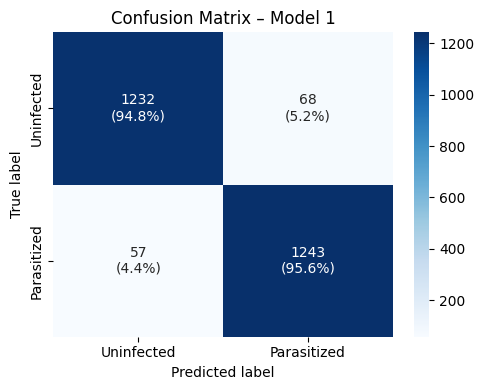

In [146]:
# Calculate percentages per true class (row-wise)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Create annotation labels: "count\n(percent%)"
annot_labels = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot_labels[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=annot_labels,
    fmt="",
    cmap="Blues",
    xticklabels=["Uninfected", "Parasitized"],
    yticklabels=["Uninfected", "Parasitized"]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Model 1")
plt.tight_layout()
plt.show()


In [43]:
print(classification_report(
    y_true,
    y_pred,
    target_names=["Uninfected", "Parasitized"]
))


              precision    recall  f1-score   support

  Uninfected       0.89      0.95      0.92      1300
 Parasitized       0.94      0.89      0.91      1300

    accuracy                           0.92      2600
   macro avg       0.92      0.92      0.92      2600
weighted avg       0.92      0.92      0.92      2600



<b> Plotting the train and the validation curves

In [151]:

#Loading history from csv
history_path = "/content/drive/MyDrive/python/model_one/history_model1.csv"
history_df = pd.read_csv(history_path)

history_df.head(), history_df.columns


(   accuracy      loss  val_accuracy  val_loss
 0  0.588951  0.665222      0.676082  0.618428
 1  0.682861  0.611277      0.698918  0.589276
 2  0.723630  0.577739      0.729768  0.547524
 3  0.807172  0.487457      0.877003  0.390889
 4  0.889412  0.341200      0.907853  0.270875,
 Index(['accuracy', 'loss', 'val_accuracy', 'val_loss'], dtype='object'))

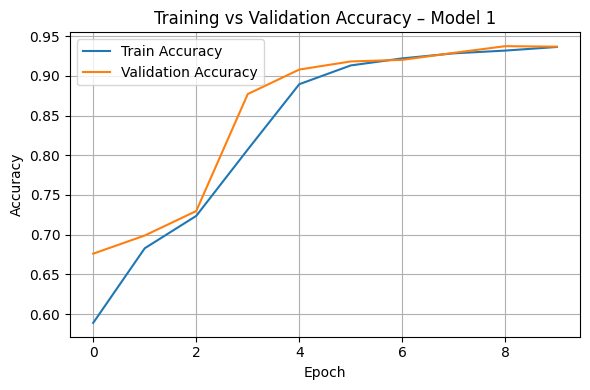

In [45]:
# Plotting accuracy curves

plt.figure(figsize=(6, 4))
plt.plot(history_df["accuracy"], label="Train Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy – Model 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


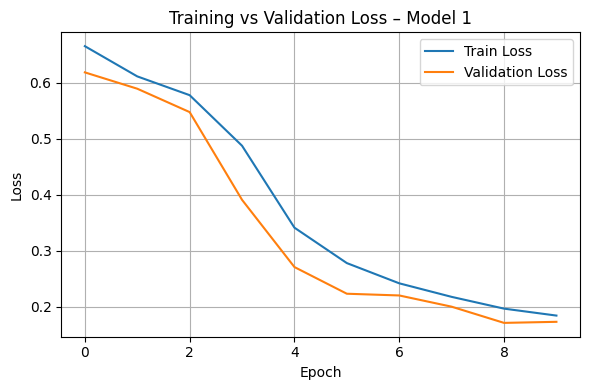

In [46]:
#Plotting loss curves
plt.figure(figsize=(6, 4))
plt.plot(history_df["loss"], label="Train Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss – Model 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


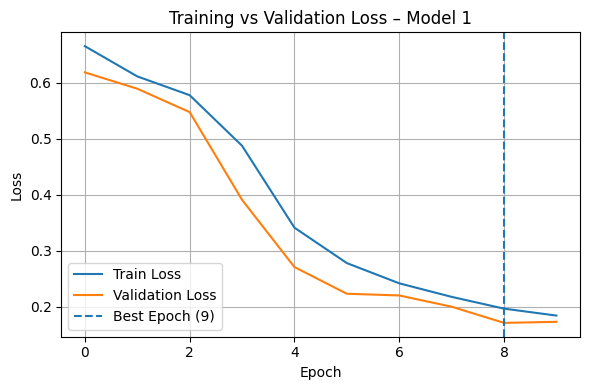

In [47]:
# Including best epoch
best_epoch_idx = history_df["val_loss"].idxmin()

plt.figure(figsize=(6, 4))
plt.plot(history_df["loss"], label="Train Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")
plt.axvline(best_epoch_idx, linestyle="--", label=f"Best Epoch ({best_epoch_idx+1})")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss – Model 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Summary of model evaluation** (Edited 19.01.2026).

Model 1 achieves a test accuracy of 91.7%, which is clearly below the baseline CNN and is consistent with the reduced representational capacity introduced by GlobalAveragePooling. On the test set, the model shows strong performance for the Uninfected class with recall 0.95 and F1-score 0.92 (precision 0.89), indicating that most non-infected cells are correctly ruled out. For the clinically critical Parasitized class, the model reaches precision 0.94 but a noticeably lower recall (sensitivity) of 0.89, resulting in an F1-score of 0.91. This pattern indicates a shift toward more conservative positive predictions (high precision) at the expense of missing more infected cells (lower recall), which aligns with the confusion matrix outcome of 57 false negatives.

While training and validation curves indicate stable convergence without signs of overfitting, the reduction in sensitivity for parasitized cells is a clinically relevant limitation. Under the defined cost- and risk-aware evaluation framework, high sensitivity is the minimum requirement for automated screening in low-resource settings, because missed infections carry substantially higher medical risk than false alarms. Overall, Model 1 is a useful architectural benchmark and demonstrates that compactness via GlobalAveragePooling can improve regularization and precision, but its reduced sensitivity makes it less suitable as a standalone screening solution compared to the baseline model.

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

Based on these questions, we build the next model using BatchNormalization layers and LeakyReLU as the activation function and evaluate its performance in comparison to the baseline and Model 1.

###<b> Model 2 with Batch Normalization

###<b> Building the Model

In [48]:
from tensorflow.keras import layers

num_classes = 2  # passt zu one-hot (2 Ausgabeneuronen)

model2 = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3)),

    # Block 1
    layers.Conv2D(32, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation="softmax"),
])

model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,498 (400.38 KB)

 Trainable params: 101,922 (398.13 KB)

 Non-trainable params: 576 (2.25 KB)

###<b>Compiling the model

In [49]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


<b> Using callbacks

In [50]:
callbacks_model2 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="best_model2_bn.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
]


<b>Fit and train the model

In [51]:
# Training deactivated – Model 2 was trained earlier and saved to Drive
RUN_TRAINING_MODEL2 = False

if RUN_TRAINING_MODEL2:
    history_model2 = model2.fit(
        train_ds_oh,
        validation_data=val_ds_oh,
        epochs=10,
        callbacks=callbacks_model2
    )
else:
    print("Model 2 training skipped.")


Epoch 1/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8144 - loss: 0.4271
Epoch 1: val_loss improved from inf to 0.16592, saving model to best_model2_bn.keras
624/624 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.8145 - loss: 0.4268 - val_accuracy: 0.9503 - val_loss: 0.1659 - learning_rate: 0.0010
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9438 - loss: 0.1621
Epoch 2: val_loss did not improve from 0.16592
624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.9438 - loss: 0.1621 - val_accuracy: 0.9135 - val_loss: 0.2242 - learning_rate: 0.0010
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9530 - loss: 0.1365
Epoch 3: val_loss did not improve from 0.16592

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
624/624 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.9530 - loss: 0.1365 - val_accuracy: 0.9557 - val_loss: 0.2074 - learning_rate: 0.0010
Epoch 4/10
622/624 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step -

In [55]:
best_model2 = tf.keras.models.load_model("best_model2_bn.keras")
best_model2.save("/content/drive/MyDrive/python/model_two/best_model2_bn.keras")

The model incorporating BatchNormalization converged very quickly and achieved strong validation performance in the first epoch. However, subsequent epochs showed a deterioration in validation loss, indicating reduced generalization. Early stopping restored the best-performing weights from the first epoch, suggesting that BatchNormalization improved training speed but did not outperform the baseline CNN in terms of validation and test performance.

<b>Plotting the train and validation accuracy


In [52]:
# Load the training history of Model 2 (with Batch Normalization) from Google Drive.
# The model was trained in an earlier session, and the history is reused here
# for analysis and plotting without retraining.

history2_df = pd.read_csv(
    "/content/drive/MyDrive/python/model_two/history_model2_bn.csv"
)

history2_df.head()



accuracy      loss  val_accuracy  val_loss  learning_rate
0  0.883903  0.295699      0.950321  0.165922         0.0010
1  0.944806  0.160404      0.913462  0.224173         0.0010
2  0.952369  0.140288      0.955729  0.207351         0.0010
3  0.960934  0.116749      0.910657  0.271499         0.0005

In [53]:
# The training history was already saved during training.
# This line is intentionally disabled to avoid overwriting existing artifacts.
# history2_df.to_csv("history_model2_bn.csv", index=False)

In [54]:
# Training history was saved during the training phase.
# Saving is intentionally disabled here to avoid overwriting existing artifacts.
# history2_df.to_csv("/content/drive/MyDrive/python/model_two/history_model2_bn.csv", index=False)

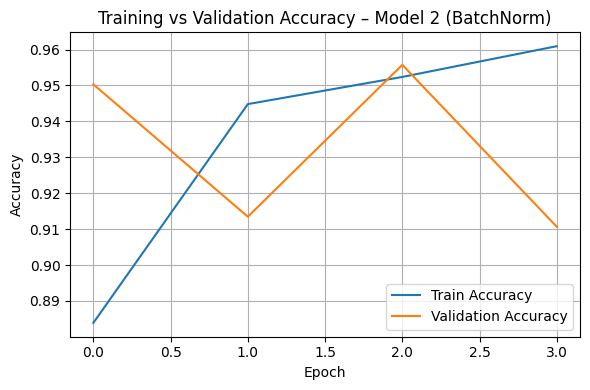

In [56]:
#Plotting the curves
history2_df = pd.read_csv(
    "/content/drive/MyDrive/python/model_two/history_model2_bn.csv"
)

plt.figure(figsize=(6, 4))
plt.plot(history2_df["accuracy"], label="Train Accuracy")
plt.plot(history2_df["val_accuracy"], label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy – Model 2 (BatchNorm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The learning curves show that the BatchNormalization model converges very quickly, achieving high validation accuracy in the first epoch. However, validation performance fluctuates strongly across subsequent epochs, indicating unstable generalization and early overfitting. As a result, BatchNormalization did not improve overall model robustness compared to the baseline CNN.

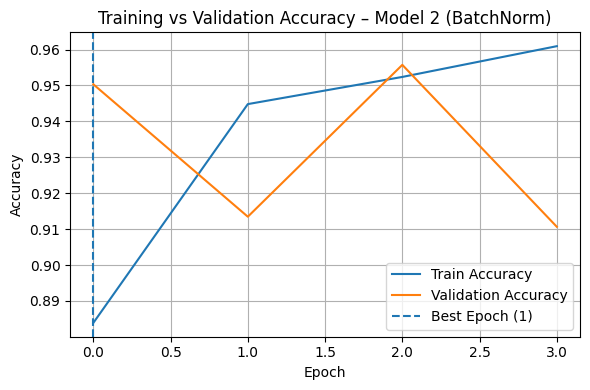

In [57]:
#Curves with best epochs
best_epoch = history2_df["val_loss"].idxmin()

plt.figure(figsize=(6, 4))
plt.plot(history2_df["accuracy"], label="Train Accuracy")
plt.plot(history2_df["val_accuracy"], label="Validation Accuracy")
plt.axvline(best_epoch, linestyle="--", label=f"Best Epoch ({best_epoch+1})")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy – Model 2 (BatchNorm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###<b>Evaluating the model

In [58]:
best_model2 = tf.keras.models.load_model(
    "/content/drive/MyDrive/python/model_two/best_model2_bn.keras"
)

In [59]:
m2_val_loss, m2_val_acc = best_model2.evaluate(val_ds_oh, verbose=1)

print("Model 2 - Val loss:", m2_val_loss)
print("Model 2 - Val acc :", m2_val_acc)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9536 - loss: 0.1614
Model 2 - Val loss: 0.16376596689224243
Model 2 - Val acc : 0.9505208134651184


In [60]:
m2_test_loss, m2_test_acc = best_model2.evaluate(test_ds_oh, verbose=1)

print("Model 2 - Test loss:", m2_test_loss)
print("Model 2 - Test acc :", m2_test_acc)


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9372 - loss: 0.1652
Model 2 - Test loss: 0.16536805033683777
Model 2 - Test acc : 0.947692334651947


####<b>Observations and insights:</b>

| Model              | Val Acc | Val Loss | Test Acc | Test Loss |
|--------------------|---------|----------|----------|-----------|
| Baseline CNN       | 0.9565  | 0.1273   | 0.9477   | 0.1420    |
| Model 1 (GAP)      | 0.9371  | 0.1700   | 0.9169   | 0.1953    |
| Model 2 (BatchNorm)| 0.9505  | 0.1638   | 0.9477   | 0.1654    |

edited 19.01.2026

The baseline CNN demonstrates the most consistent and robust performance across both validation and test datasets, achieving the highest validation accuracy and the lowest loss values. Its stable training behavior and strong generalization indicate that the baseline architecture effectively captures the relevant visual patterns present in the data without requiring additional architectural complexity.

Model 1, which incorporates GlobalAveragePooling to reduce the number of trainable parameters, consistently underperforms the baseline on both validation and test sets. While the reduced capacity helps limit overfitting, it also appears to remove fine-grained spatial information that is important for detecting malaria parasites. This suggests that preserving localized spatial features is critical for this classification task.

Model 2, which introduces BatchNormalization, converges very rapidly and achieves a test accuracy comparable to the baseline CNN. However, it shows higher validation and test loss values, indicating less confident predictions and less stable generalization. This suggests that while BatchNormalization improves optimization dynamics and convergence speed, it does not provide a clear advantage in terms of final model performance for this dataset.

Overall, architectural modifications such as GlobalAveragePooling and BatchNormalization influence training behavior but do not consistently improve generalization performance. In this study, a relatively simple CNN architecture proves to be the most effective, highlighting that increased architectural complexity does not necessarily translate into better performance for medical image classification tasks.

<b> Generate the classification report and confusion matrix

In [68]:
# Classification reports and confusion matrices were generated from explicit model predictions to enable class-wise performance analysis.

y_true = []
y_pred = []

for x_batch, y_batch in test_ds_oh:
    preds = model2.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y_batch.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [69]:
print(classification_report(
    y_true,
    y_pred,
    target_names=["Uninfected", "Parasitized"]
))

              precision    recall  f1-score   support

  Uninfected       0.95      0.95      0.95      1300
 Parasitized       0.95      0.95      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [70]:
# Calculating confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[1231,   69],
       [  67, 1233]])

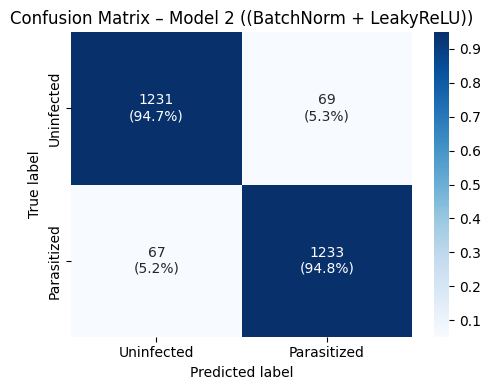

In [71]:
# Plotting confusion matrix
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
labels = np.empty_like(cm).astype(str)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        labels[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]*100:.1f}%)"

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_percent,
    annot=labels,
    fmt="",
    cmap="Blues",
    xticklabels=["Uninfected", "Parasitized"],
    yticklabels=["Uninfected", "Parasitized"]
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Model 2 ((BatchNorm + LeakyReLU))")
plt.tight_layout()
plt.show()


Model 2, which incorporates BatchNormalization and LeakyReLU activations, achieves a test accuracy of 94.8%, matching the baseline CNN in terms of overall classification performance. The classification report shows balanced performance across both classes, with precision, recall, and F1-score of 0.95 for parasitized and uninfected cells, indicating a well-calibrated decision boundary without strong class bias.

Compared to Model 1, Model 2 substantially improves sensitivity for parasitized cells, reducing the number of missed infections and restoring recall to a level comparable to the baseline. This shift in the error distribution reflects a clinically favorable trade-off for screening scenarios, as higher sensitivity reduces the risk of undetected malaria cases, even if it may result in a slightly increased false positive rate.

However, despite this improvement in class-wise balance, the learning curves reveal rapid convergence accompanied by noticeable fluctuations in validation accuracy across epochs. This suggests that BatchNormalization improves optimization dynamics but does not consistently enhance generalization stability or robustness in this setting. Consequently, while Model 2 demonstrates a clear improvement over Model 1 and achieves baseline-level sensitivity and F1-score, it does not yet provide a decisive performance or robustness advantage over the baseline CNN.

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





Yes, data augmentation can potentially improve generalization by exposing the model to realistic variations in cell orientation, illumination, and scale. In a medical context, carefully designed augmentation can reduce false negatives by improving robustness to natural variability in blood smear preparation, such as differences in staining intensity, microscope settings, or cell orientation, thereby enabling more reliable detection of infected cells across laboratories and field conditions. However, for microscopy images, augmentation should remain conservative, as overly aggressive transformations may obscure or distort diagnostically relevant parasite structures and increase misclassification rates. Therefore, augmentation strategies must be clinically informed and validated empirically using the same data split and evaluation metrics, with particular emphasis on sensitivity and false negative rates, as missed infections pose a higher risk than false positives in malaria screening.

###<b>Model 3 with Data Augmentation

In [84]:
# Model 3: Augmentation setup (same architecture as Model 2, different training procedure)

from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),   # ~ +/- 15°
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.10),
], name="data_augmentation")

In [85]:
# Build augmented training dataset (augmentation + one-hot labels)

num_classes = 2

train_ds_aug = train_ds.map(
    lambda x, y: (
        data_augmentation(x, training=True),
        tf.one_hot(tf.cast(y, tf.int32), num_classes)
    ),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

# keep these for later steps (no label change here)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


In [86]:
# Create Model 3 by cloning Model 2 architecture + compile for one-hot labels

model3 = tf.keras.models.clone_model(model2)
model3.build((None, 128, 128, 3))

model3.compile(
    optimizer=model2.optimizer.__class__.from_config(model2.optimizer.get_config()),
    loss="categorical_crossentropy",   # one-hot labels -> categorical_crossentropy
    metrics=["accuracy"]
)

model3.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,498 (400.38 KB)

 Trainable params: 101,922 (398.13 KB)

 Non-trainable params: 576 (2.25 KB)

###<b> Use image data generator

In this project, image data augmentation is applied during training rather than during data loading.
Here, loading refers to the process of reading and decoding image files from disk into memory, while training refers to feeding already loaded data into the model.

In many traditional workflows, images are augmented at the moment they are read from disk. In this case, transformations are applied between disk and memory, so the images are already modified when they reach the model. This approach is commonly referred to as augmentation during loading.

In contrast, the images in this project are first loaded into a tf.data.Dataset pipeline (train_ds, val_ds, test_ds) and stored in memory in their original form. Augmentation is then applied after loading, during training, by mapping augmentation layers onto the training dataset. This allows each image to be randomly transformed at every epoch, while validation and test datasets remain unchanged.

Both approaches are conceptually equivalent in terms of learning objective; the difference lies solely in when the augmentation is applied in the data pipeline.

In [87]:
# Callbacks for Model 3

callbacks_model3 = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model3_aug.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
]


In [88]:
#Validation dataset (NO augmentation, but one-hot labels)

val_ds_oh = val_ds.map(
    lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), 2)),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)


In [89]:
# Sanity checks (optional, but recommended once)

for _, y in train_ds_aug.take(1):
    print("train_ds_aug y shape:", y.shape)

for _, y in val_ds_oh.take(1):
    print("val_ds_oh y shape:", y.shape)


train_ds_aug y shape: (32, 2)
val_ds_oh y shape: (32, 2)


In [90]:
# Model Fit with Augmentation

RUN_TRAINING_MODEL3 = False

if RUN_TRAINING_MODEL3:
    history_model3 = model3.fit(
        train_ds_aug,
        validation_data=val_ds_oh,
        epochs=10,
        callbacks=callbacks_model3
    )


Epoch 1/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8053 - loss: 0.4362
Epoch 1: val_loss improved from inf to 0.20474, saving model to best_model3_aug.keras
624/624 ━━━━━━━━━━━━━━━━━━━━ 90s 132ms/step - accuracy: 0.8054 - loss: 0.4360 - val_accuracy: 0.9241 - val_loss: 0.2047
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9418 - loss: 0.1692
Epoch 2: val_loss did not improve from 0.20474
624/624 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - accuracy: 0.9418 - loss: 0.1691 - val_accuracy: 0.5443 - val_loss: 1.4863
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9511 - loss: 0.1447
Epoch 3: val_loss did not improve from 0.20474
624/624 ━━━━━━━━━━━━━━━━━━━━ 90s 140ms/step - accuracy: 0.9511 - loss: 0.1447 - val_accuracy: 0.5553 - val_loss: 1.5308
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9535 - loss: 0.1334
Epoch 4: val_loss improved from 0.20474 to 0.11721, saving model to best_model3_aug.keras
624/624 ━━━━━━━━━━

In [94]:
# Define and create the directory for Model 3 artifacts (models, history, checkpoints)
# The directory is created if it does not already exist.

import os

MODEL3_DIR = "/content/drive/MyDrive/python/model_three"
os.makedirs(MODEL3_DIR, exist_ok=True)


In [95]:
# Load the best Model 3 checkpoint and store it in the dedicated Model 3 directory
# to keep all Model 3 artifacts organized in Google Drive.

best_model3 = tf.keras.models.load_model("best_model3_aug.keras")
best_model3.save(os.path.join(MODEL3_DIR, "best_model3_aug.keras"))

In [96]:
# Save the training history of Model 3 to Google Drive
# (executed once directly after training Model 3)

history_df = pd.DataFrame(history_model3.history)
history_df.to_csv(
    os.path.join(MODEL3_DIR, "history_model3_aug.csv"),
    index=False
)


**Validation Dataset Check (One-Hot Encoding & Shape Sanity Check)**




Validation Dataset Inspection After Unstable Validation Performance

During training, the validation metrics showed strong instability in early epochs, with a sudden drop in validation accuracy (≈ 0.55 in epochs 2–3) despite steadily improving training accuracy. Such behavior can indicate issues in the validation pipeline rather than genuine model degradation.

To rule out technical causes, the validation dataset was explicitly inspected.

In [103]:
#Label-encoding check
for _, y in val_ds_oh.take(1):
    print("val_ds_oh y shape:", y.shape, "min/max:", tf.reduce_min(y).numpy(), tf.reduce_max(y).numpy())


val_ds_oh y shape: (32, 2) min/max: 0.0 1.0


This check verifies that the validation labels are correctly one-hot encoded.
Inspecting a single batch confirms that labels have shape (batch_size, 2) and contain only 0/1 values, which is required for training and validating a model with a softmax output layer and categorical cross-entropy loss.

In [104]:
#Validation Pipeline Structure Check
print(val_ds_oh)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


Inspection of the dataset specification confirms that the input images have the expected shape (128 × 128 × 3), the label encoding matches the model’s output dimensionality, no data augmentation is applied to the validation pipeline, and prefetching is enabled purely for performance optimization without affecting data semantics. This structurally sound validation setup is particularly important in a medical screening use case, as it ensures that validation metrics reflect true generalization rather than artifacts of data handling. Consequently, the observed performance fluctuations in early epochs cannot be attributed to label encoding errors or dataset construction, but are more plausibly caused by stochastic effects introduced by data augmentation and batch normalization during training. Validation metrics from later epochs can therefore be interpreted as reliable indicators of clinically relevant generalization performance, especially with respect to sensitivity and false negative rates, which are critical for large-scale malaria screening applications.

###**Think About It :**<br>

Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.


In Model 3, data augmentation was applied during training to increase data diversity and improve generalization. While this already led to a slight improvement in validation performance, augmentation itself introduces additional stochasticity and effectively changes the learning task.

Potential improvements could be explored by adjusting the augmentation strength and composition, for example:

* reducing or increasing rotation and zoom ranges,
* selectively disabling transformations that may distort diagnostically relevant features,
* testing asymmetric augmentations (e.g. horizontal flips only),
* or tuning augmentation intensity to better balance robustness and stability.

Such experiments may help reduce validation instability in early epochs and potentially improve recall for the Parasitized class, but they require careful evaluation to avoid introducing unrealistic image variations that could harm clinical interpretability.

**Practical Consideration**

While additional fine-tuning of data augmentation parameters could further improve performance, no extensive augmentation ablation studies were conducted within the scope of this project. The primary focus was on maintaining architectural comparability across models and limiting the number of simultaneously varying experimental factors.

Importantly, the results indicate that the augmentation-based Model 3 already achieves the strongest and most consistent validation performance among the evaluated variants. This suggests that data augmentation is a promising direction for further improvement. Consequently, more targeted augmentation tuning (e.g., intensity ranges, probability schedules, or augmentation combinations) represents a natural next step and is explicitly identified as future work aimed at further optimizing sensitivity and overall F1-score in a screening context.


In [43]:
# Load the trained Model 3 from Google Drive for evaluation

model3 = tf.keras.models.load_model(
    "/content/drive/MyDrive/python/model_three/best_model3_aug.keras"
)

model3.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,344 (1.17 MB)

 Trainable params: 101,922 (398.13 KB)

 Non-trainable params: 576 (2.25 KB)

 Optimizer params: 203,846 (796.28 KB)

In [44]:
# Sanity check: verify the label encoding used in the test datasets.
for _, y in test_ds.take(1):
    print("test_ds y shape:", y.shape)


for _, y in test_ds_oh.take(1):
    print("test_ds_oh y shape:", y.shape)

test_ds y shape: (32,)
test_ds_oh y shape: (32, 2)


In [45]:
#Model evaluation
# Predict probabilities (Model 3 outputs softmax probs of shape (n, 2))
y_pred_prob = model3.predict(test_ds_oh)

# Convert probs -> class label
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels: one-hot -> class label
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds_oh])

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=["Parasitized", "Uninfected"]))




82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
Confusion Matrix:
 [[1248   52]
 [  30 1270]]

Classification Report:
               precision    recall  f1-score   support

 Parasitized       0.98      0.96      0.97      1300
  Uninfected       0.96      0.98      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



In [46]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1248   52]
 [  30 1270]]


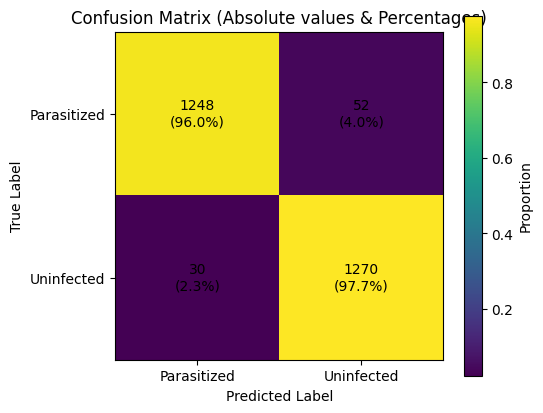

In [48]:
# Confusion matrix from your results
cm = np.array([[1248, 52],
               [30, 1270]])

class_names = ["Parasitized", "Uninfected"]

# Normalisieren
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5.5, 4.5))
plt.imshow(cm_norm)
plt.title("Confusion Matrix (Absolute values & Percentages)")
plt.colorbar(label="Proportion")

plt.xticks(ticks=[0, 1], labels=class_names)
plt.yticks(ticks=[0, 1], labels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Text: absolute Zahl + Prozent
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i,
            f"{cm[i, j]}\n({cm_norm[i, j]*100:.1f}%)",
            ha="center", va="center"
        )

plt.tight_layout()
plt.show()



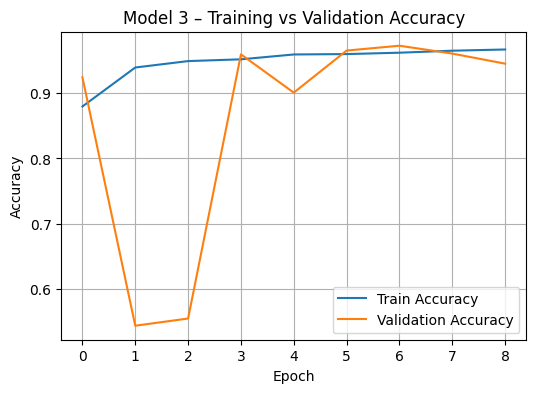

In [145]:
# Plot training vs validation accuracy for Model 3
history3 = pd.read_csv("/content/drive/MyDrive/python/model_three/history_model3_aug.csv")

plt.figure(figsize=(6, 4))
plt.plot(history3["accuracy"], label="Train Accuracy")
plt.plot(history3["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model 3 – Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

edited, 19.01.2026: Model 3, which combines BatchNormalization with data augmentation during training, achieves the strongest performance among the evaluated models, with a test accuracy of 97.0% and balanced class-wise metrics. The classification report shows a recall (sensitivity) of 96.0% for parasitized cells, indicating a high ability to correctly detect infected red blood cells, while uninfected cells achieve a recall of 97.7%, suggesting no relevant class bias. Precision is similarly high for both classes (0.98 for parasitized, 0.96 for uninfected), resulting in a class-wise F1-score of approximately 0.97.

The confusion matrix confirms this balanced error profile, with 52 false negatives (missed infected cells) and 30 false positives. From a medical screening perspective, false negatives represent the most critical error type, as they correspond to untreated infections. Compared to the baseline CNN and earlier architectural variants, Model 3 reduces the overall number of misclassifications while maintaining a favorable sensitivity–specificity balance, aligning well with the defined cost- and risk-aware evaluation criteria.

Although the training curves exhibit volatility in early epochs—consistent with the stochastic effects introduced by data augmentation—the validation performance stabilizes in later epochs and closely tracks training accuracy. This indicates that the model generalizes well once sufficient exposure to augmented variability is achieved. Taken together, these results suggest that augmentation-enhanced training improves robustness under realistic variability in microscopy images and yields a clinically meaningful improvement in sensitivity and overall F1-score. So far, **Model 3 represents the most promising configuration for automated malaria screening**, particularly in low-resource settings where high sensitivity and reliable generalization are essential.

####<B>Visualizing Augmented images

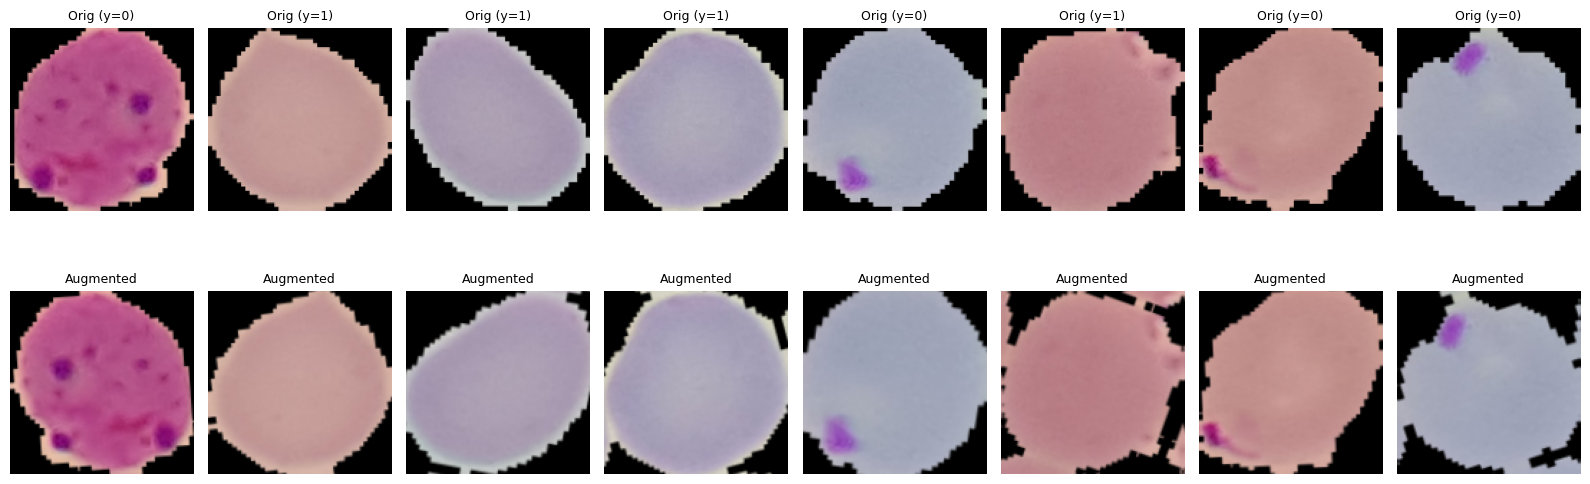

In [106]:
# Visualizing Augmented Images (Original vs. Augmented)

images, labels = next(iter(train_ds))
aug_images = data_augmentation(images, training=True)

n = 8
plt.figure(figsize=(16, 6))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    img = tf.clip_by_value(images[i], 0.0, 1.0)
    plt.imshow((img * 255).numpy().astype("uint8"))
    plt.title(f"Orig (y={int(labels[i].numpy())})", fontsize=9)
    plt.axis("off")

    # Augmented
    ax = plt.subplot(2, n, n + i + 1)
    aug = tf.clip_by_value(aug_images[i], 0.0, 1.0)
    plt.imshow((aug * 255).numpy().astype("uint8"))
    plt.title("Augmented", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


Visual inspection of augmented samples shows that geometric and photometric transformations introduce realistic variability while preserving cell morphology and diagnostically relevant features. This supports the use of augmentation as a regularization strategy rather than a source of label noise.

**Model Performance Overview** edited, 19.01.2026

The augmentation-enhanced CNN (Model 3) demonstrates strong overall performance on the test dataset, achieving a test accuracy of 97%. As both classes (Parasitized and Uninfected) are equally represented in the test set, this evaluation provides a balanced and reliable assessment of the model’s classification behavior. Precision, recall, and F1-scores are consistently high for both classes (≈ 0.97), indicating robust generalization and the absence of systematic class bias. Importantly, the model satisfies the predefined minimum sensitivity requirement for automated malaria screening.

**Confusion Matrix Analysis**

A closer inspection of the confusion matrix shows that:

* 1248 out of 1300 parasitized cells are correctly classified.
* 52 parasitized cells (≈ 4%) are misclassified as uninfected (false negatives).
* 1270 out of 1300 uninfected cells are correctly identified.
* 30 uninfected cells are misclassified as parasitized (false positives).

Overall, the absolute number of misclassifications is low, and the error distribution remains well balanced, with a moderate asymmetry toward missed infections rather than false alarms.

**Medical Interpretation of Errors**

In a medical screening context, false negatives represent the most critical error type, as undetected parasitized cells may delay diagnosis and treatment. Although the false-negative rate is relatively low, even small proportions of missed infections can become clinically relevant when scaled to large screening populations in low-resource settings. At the same time, the limited number of false positives indicates that the model does not excessively increase follow-up workload or unnecessary treatment, which is essential in environments with constrained diagnostic capacity.

**Key Insights**

The model achieves high and well-balanced performance across both classes.

* Sensitivity and precision are jointly high, resulting in a strong F1-score, consistent with the defined cost- and risk-aware evaluation strategy.

* Validation and test behavior indicate stable generalization despite the additional variability introduced by data augmentation.

* Remaining classification errors reflect a typical sensitivity–specificity trade-off in medical image analysis rather than systematic failure modes.

**Conclusion of Evaluation**

Within the scope of this study, the augmentation-based CNN (Model 3) represents the most promising configuration evaluated so far, combining high accuracy, strong sensitivity, and balanced class-wise performance. These characteristics make it well suited for automated assistance or preliminary malaria screening, particularly in low-resource settings where high sensitivity is essential. Nevertheless, for high-stakes clinical deployment, further optimization—such as sensitivity-focused threshold tuning, class weighting, or exploration of pretrained architectures—would be required to further reduce the residual risk of missed infections.

### Model Comparison Overview (after Model 3)

| Model | Key Architecture Features | Test Accuracy | Recall (Parasitized) | Precision (Parasitized) | F1-score (Parasitized) | False Negatives | Remarks |
|------|---------------------------|---------------|----------------------|--------------------------|------------------------|----------------|---------|
| Baseline CNN | Standard CNN | 0.9477 | 0.965 | 0.96 | 0.95 | 46 | Strong baseline, stable generalization |
| Model 1 (GAP) | GlobalAveragePooling | 0.9169 | 0.889 | 0.94 | 0.91 | 57 | Reduced capacity, sensitivity drop |
| Model 2 (BN + LeakyReLU) | BatchNorm, LeakyReLU | 0.9477 | 0.95 | 0.95 | 0.95 | 67 | Baseline-level sensitivity, limited robustness gain |
| **Model 3 (BN + Aug)** | BatchNorm + Data Augmentation | **0.9700** | **0.960** | **0.98** | **0.97** | **52** | Best balance so far, clinically promising |

Taken together, the comparative results show a clear progression from architectural simplification toward robustness-enhancing strategies. While parameter reduction and normalization alone did not consistently improve screening-relevant metrics, the combination of BatchNormalization with data augmentation yields the strongest performance observed so far, particularly in terms of sensitivity and F1-score.

Despite this improvement, the remaining false negatives indicate that further optimization is still warranted for high-stakes screening scenarios. The next model therefore explores whether more expressive architectures or alternative feature representations can further reduce missed infections while maintaining the robustness gains achieved through augmentation.


###<b>Building the Model (its not clear, which model or based on what it should be created. That's why I am using another pretrained model)

Model 4 introduces Transfer Learning: we reuse a CNN backbone pre-trained on ImageNet (MobileNetV2) as a fixed feature extractor and train only a lightweight classification head for malaria detection.
This provides a clear methodological contrast to Models 1–3, which learn features from scratch (with Model 3 additionally using data augmentation).

In [68]:
# Control flags and file paths

# Set to False if the model was already trained
# and should be loaded from Google Drive instead
RUN_TRAINING = True

# Paths for saving/loading model and training history
MODEL4_PATH = "/content/drive/MyDrive/python/model_four/malaria_model4_mobilenetv2.keras"
HIST4_PATH  = "/content/drive/MyDrive/python/model_four/malaria_history4_mobilenetv2.npy"


In [69]:
# Architecture (Transfer Learning)
# We use MobileNetV2 pre-trained on ImageNet
# as a fixed feature extractor (no weight updates).

IMG_SIZE = (128, 128)
NUM_CLASSES = 2

# Load pre-trained MobileNetV2 backbone
base_mnv2 = tf.keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze the backbone to avoid retraining millions of parameters
base_mnv2.trainable = False

# Build the full model
inputs = layers.Input(shape=(*IMG_SIZE, 3))

# Apply MobileNetV2-specific preprocessing
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)

# Extract visual features using the frozen backbone
x = base_mnv2(x, training=False)

# Reduce spatial dimensions
x = layers.GlobalAveragePooling2D()(x)

# Regularization to reduce overfitting
x = layers.Dropout(0.3)(x)

# Final classification layer
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model4 = tf.keras.Model(inputs, outputs, name="Model4_MobileNetV2_TL")

# Display model structure
model4.summary()


Model: "Model4_MobileNetV2_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [70]:
# Compile

# categorical_crossentropy is used because the labels
# are one-hot encoded (shape: [batch_size, 2])

model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


<b>Using Callbacks

In [71]:
# Callbacks
# EarlyStopping prevents overfitting by stopping training
# when validation accuracy stops improving.
# ReduceLROnPlateau lowers the learning rate when validation
# loss plateaus, enabling finer convergence.

callbacks_model4 = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1
    )
]


In [75]:
# Create one-hot training dataset
# train_ds currently has sparse labels (shape: [batch])
# We convert them to one-hot labels (shape: [batch, 2]) for categorical_crossentropy.

NUM_CLASSES = 2

train_ds_oh = train_ds.map(
    lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), NUM_CLASSES))
)

# Sanity check
for _, y in train_ds_oh.take(1):
    print("train_ds_oh y shape:", y.shape)


train_ds_oh y shape: (32, 2)


In [82]:
val_ds_oh = val_ds.map(
    lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), NUM_CLASSES))
)

# Sanity check
for _, y in val_ds_oh.take(1):
    print("val_ds_oh y shape:", y.shape)   # erwartet: (batch, 2)


val_ds_oh y shape: (32, 2)


<b> Fit and Train the model

In [83]:
# This trains only the classification head because the MobileNetV2 backbone is frozen.

history4 = model4.fit(
    train_ds_oh,
    validation_data=val_ds_oh,
    epochs=10,
    callbacks=callbacks_model4
)


Epoch 1/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 55s 51ms/step - accuracy: 0.5128 - loss: 0.7332 - val_accuracy: 0.5318 - val_loss: 0.6841 - learning_rate: 0.0010
Epoch 2/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.5295 - loss: 0.7013 - val_accuracy: 0.6119 - val_loss: 0.6745 - learning_rate: 0.0010
Epoch 3/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.5417 - loss: 0.6906 - val_accuracy: 0.6235 - val_loss: 0.6729 - learning_rate: 0.0010
Epoch 4/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5573 - loss: 0.6853 - val_accuracy: 0.5098 - val_loss: 0.7094 - learning_rate: 0.0010
Epoch 5/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.5565 - loss: 0.6889 - val_accuracy: 0.6164 - val_loss: 0.6702 - learning_rate: 0.0010
Epoch 6/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5641 - loss: 0.6833 - val_accuracy: 0.6404 - val_loss: 0.6630 - learning_rate: 0.0010
Epoch 7/10
780/780 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5660 - l

Steps per epoch differ across models due to changes in dataset splitting and batch size. Therefore, results are compared qualitatively rather than as strictly identical training setups.

Training selected the best checkpoint at epoch 8 (highest validation performance), and the final model weights were restored from that epoch.

In [84]:
#Save after training

# Save trained model
model4.save(MODEL4_PATH)

# Save training history (raw dict for reproducibility)
np.save(HIST4_PATH, history4.history)

# Also save history as CSV for analysis and reporting
history_df = pd.DataFrame(history4.history)
history_df.to_csv(
    HIST4_PATH.replace(".npy", ".csv"),
    index=False
)

print("Saved model to:", MODEL4_PATH)
print("Saved history (NPY) to:", HIST4_PATH)
print("Saved history (CSV) to:", HIST4_PATH.replace(".npy", ".csv"))

Saved model to: /content/drive/MyDrive/python/model_four/malaria_model4_mobilenetv2.keras
Saved history (NPY) to: /content/drive/MyDrive/python/model_four/malaria_history4_mobilenetv2.npy
Saved history (CSV) to: /content/drive/MyDrive/python/model_four/malaria_history4_mobilenetv2.csv


###<B>Evaluating the model

<b>Plot the train and validation accuracy


Model 4 is evaluated based on test-set performance; training dynamics are omitted as the model was loaded from disk and not retrained in this session.

In [85]:
test_loss4, test_acc4 = model4.evaluate(test_ds_oh)
print("Model 4 - Test loss:", test_loss4)
print("Model 4 - Test accuracy:", test_acc4)


82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 226ms/step - accuracy: 0.6947 - loss: 0.6315
Model 4 - Test loss: 0.6715007424354553
Model 4 - Test accuracy: 0.6100000143051147


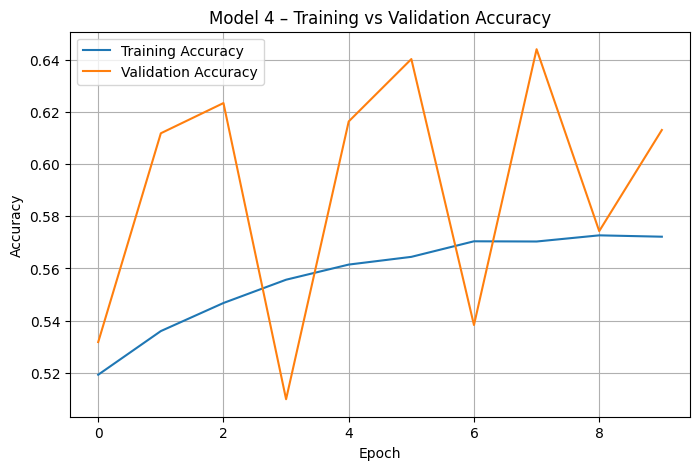

In [86]:
# Load history into DataFrame
history_df = pd.DataFrame(history4.history)

plt.figure(figsize=(8, 5))
plt.plot(history_df["accuracy"], label="Training Accuracy")
plt.plot(history_df["val_accuracy"], label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model 4 – Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Training accuracy increases steadily, indicating stable learning of the classification head. Validation accuracy fluctuates considerably across epochs, suggesting limited generalization due to the frozen MobileNetV2 backbone and suboptimal feature alignment with the malaria cell images.

<B>Plotting the classification report and confusion matrix

In [87]:
test_loss4, test_acc4 = model4.evaluate(test_ds_oh)
print("Model 4 - Test loss:", test_loss4)
print("Model 4 - Test accuracy:", test_acc4)


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6947 - loss: 0.6315
Model 4 - Test loss: 0.6715007424354553
Model 4 - Test accuracy: 0.6100000143051147


In [88]:
# Predict probabilities on test set
y_pred_prob = model4.predict(test_ds_oh)
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels from one-hot encoded test set
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds_oh])

82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step


In [92]:
# A) Classification Report (Precision / Recall / F1)
report = classification_report(
    y_true,
    y_pred,
    target_names=["Parasitized", "Uninfected"]
)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

 Parasitized       0.58      0.77      0.66      1300
  Uninfected       0.66      0.45      0.54      1300

    accuracy                           0.61      2600
   macro avg       0.62      0.61      0.60      2600
weighted avg       0.62      0.61      0.60      2600



In [93]:
# B) Confusion Matrix (counts of correct/incorrect predictions)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[995 305]
 [709 591]]


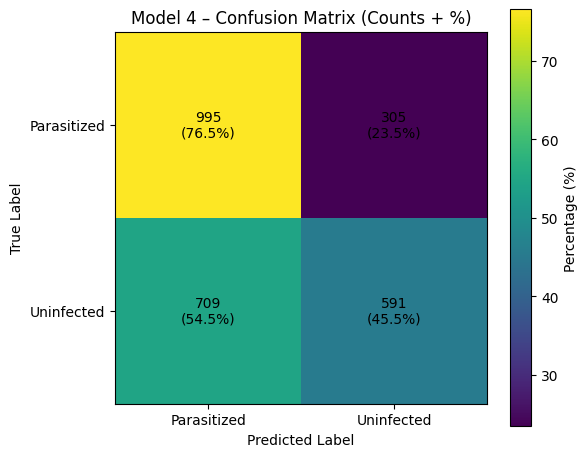

In [96]:
# C) Plot Confusion Matrix

# 5) Normalize confusion matrix to percentages (row-wise)
#    Each row sums to 100% -> per true class
cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100


# 6) Plot confusion matrix with percentages
plt.figure(figsize=(6, 5))
plt.imshow(cm_percent)
plt.title("Model 4 – Confusion Matrix (Counts + %)")
plt.colorbar(label="Percentage (%)")

class_names = ["Parasitized", "Uninfected"]
plt.xticks([0, 1], class_names)
plt.yticks([0, 1], class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Write absolute counts and percentages into each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j,
            i,
            f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)",
            ha="center",
            va="center"
        )

plt.tight_layout()
plt.show()

edited 19.01.2026

**Model 4 – Evaluation (Transfer Learning with Frozen MobileNetV2)
Training and Validation Behavior**

During training, Model 4 shows a steady increase in training accuracy, indicating that the classification head learns consistently on top of the frozen MobileNetV2 backbone. In contrast, validation accuracy fluctuates considerably across epochs without a clear upward trend. This divergence suggests limited generalization and indicates that the fixed feature representations provided by the pretrained backbone are not well aligned with the characteristics of malaria cell images. The observed instability in validation performance points to a mismatch between generic features learned from natural images and the domain-specific patterns required for parasite detection.

**Test Set Performance and Error Analysis**

On the test set, Model 4 achieves an overall accuracy of approximately 61%, which is substantially lower than that of all previously evaluated fully trainable CNN models. The confusion matrix reveals a highly unfavorable error distribution for a medical screening application. While 995 out of 1300 parasitized cells (76.5%) are correctly identified, 305 infected cells (23.5%) are missed, resulting in an unacceptably high false-negative rate. In parallel, only 591 out of 1300 uninfected cells (45.5%) are correctly classified, leading to a large number of false positives and indicating weak class separation.

The classification report confirms this imbalance, with a recall (sensitivity) of 0.77 for parasitized cells and 0.45 for uninfected cells, accompanied by low class-wise F1-scores (0.66 and 0.54, respectively). This combination reflects poor sensitivity–specificity balance and fails to meet the minimum requirements defined for automated malaria screening in low-resource settings.

**Interpretation in the Context of Model History and Use Case**

In contrast to Models 0–3, which were trained end-to-end with all convolutional layers adapting to the malaria dataset, Model 4 relies on a frozen MobileNetV2 backbone, restricting learning to the classification head. As a result, the model cannot sufficiently adapt its feature representations to subtle parasite morphology, staining variability, and cell-level texture patterns. This limitation explains both the pronounced validation instability and the poor test-set performance.

From a use-case perspective, the high number of missed infections represents a critical failure mode. Given the cost- and risk-aware evaluation framework, Model 4 does not satisfy the minimum sensitivity requirement and is therefore excluded from further consideration as a screening solution. While the transfer learning approach itself is technically valid, competitive performance would likely require unfreezing and fine-tuning higher-level backbone layers with a reduced learning rate. Without such adaptations, this configuration is not suitable for medical decision support or large-scale malaria screening.

**Position in the Overall Model Progression**

Taken together with the results of Models 0–3, Model 4 highlights an important methodological insight: for domain-specific medical imaging tasks with subtle discriminative features, fully trainable CNNs or carefully fine-tuned pretrained models outperform frozen transfer learning setups. In the current configuration, Model 3 clearly remains the most effective and clinically relevant model evaluated so far.

### Model Comparison Overview (after Model 4)

| Model | Key Architecture Features | Test Accuracy | Recall (Parasitized) | Precision (Parasitized) | F1-score (Parasitized) | False Negatives | Remarks |
|------|---------------------------|---------------|----------------------|--------------------------|------------------------|----------------|---------|
| Baseline CNN (Model 0) | Standard CNN | 0.9477 | 0.965 | 0.96 | 0.95 | 46 | Strong baseline, stable generalization |
| Model 1 (GAP) | GlobalAveragePooling | 0.9169 | 0.889 | 0.94 | 0.91 | 57 | Reduced capacity, sensitivity drop |
| Model 2 (BN + LeakyReLU) | BatchNorm, LeakyReLU | 0.9477 | 0.95 | 0.95 | 0.95 | 67 | Baseline-level performance |
| **Model 3 (BN + Aug)** | BatchNorm + Data Augmentation | **0.9700** | **0.960** | **0.98** | **0.97** | **52** | Best balance so far, clinically promising |
| Model 4 (Frozen TL) | MobileNetV2 (frozen backbone) | 0.61 | 0.77 | 0.58 | 0.66 | 305 | Fails sensitivity requirement |


The results obtained with Model 4 highlight an important limitation of frozen transfer learning in this domain. While pretrained backbones such as MobileNetV2 provide powerful generic feature representations, freezing the convolutional layers prevents sufficient adaptation to domain-specific characteristics of malaria microscopy images.

Given the strong performance of end-to-end trained models (especially Model 3) and the clear shortcomings observed when using a fully frozen backbone, the next model explores whether transfer learning can be made effective by selectively unfreezing and fine-tuning higher-level convolutional layers. The goal is to combine the representational strength of pretrained features with domain-specific adaptation, while maintaining high sensitivity and F1-score under the defined screening-oriented evaluation framework.


In [97]:
# 1) Find the MobileNetV2 backbone inside model4
base_model = None
for layer in model4.layers:
    if isinstance(layer, tf.keras.Model) and "mobilenet" in layer.name.lower():
        base_model = layer
        break

if base_model is None:
    raise ValueError("Could not find MobileNetV2 backbone inside model4.")

print("Backbone found:", base_model.name)
print("Backbone layers:", len(base_model.layers))

# 2) Unfreeze the backbone, but only fine-tune the TOP layers
base_model.trainable = True

# Adjust this number if you want more/less fine-tuning
# Common choice: keep early layers frozen, train last ~20-50 layers
FINE_TUNE_AT = len(base_model.layers) - 30   # train last 30 layers

for i, layer in enumerate(base_model.layers):
    # Keep earlier layers frozen
    if i < FINE_TUNE_AT:
        layer.trainable = False
    else:
        layer.trainable = True

# 3) IMPORTANT: keep BatchNorm layers frozen for stable fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

print("Fine-tuning from layer:", FINE_TUNE_AT)
print("Trainable layers in backbone:",
      sum([1 for l in base_model.layers if l.trainable]))

Backbone found: mobilenetv2_1.00_128
Backbone layers: 154
Fine-tuning from layer: 124
Trainable layers in backbone: 19


In [98]:
# Recompile + fine-tune (small learning rate)

# Use a much smaller LR for fine-tuning
fine_tune_lr = 1e-5

model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss="categorical_crossentropy",          # because we use one-hot labels
    metrics=["accuracy"]
)

# Optional: reuse your callbacks (or define minimal ones here)
callbacks_ft = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7
    )
]

# Fine-tune for a few epochs (usually 3-10 is enough)
history4_ft = model4.fit(
    train_ds_oh,
    validation_data=val_ds_oh,
    epochs=8,
    callbacks=callbacks_ft
)

Epoch 1/8
780/780 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.5312 - loss: 0.7043 - val_accuracy: 0.4970 - val_loss: 0.6946 - learning_rate: 1.0000e-05
Epoch 2/8
780/780 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.5273 - loss: 0.6912 - val_accuracy: 0.5685 - val_loss: 0.6893 - learning_rate: 1.0000e-05
Epoch 3/8
780/780 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.5267 - loss: 0.6908 - val_accuracy: 0.5040 - val_loss: 0.6904 - learning_rate: 1.0000e-05
Epoch 4/8
780/780 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.5285 - loss: 0.6911 - val_accuracy: 0.5340 - val_loss: 0.6883 - learning_rate: 1.0000e-05
Epoch 5/8
780/780 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.5269 - loss: 0.6916 - val_accuracy: 0.6174 - val_loss: 0.6880 - learning_rate: 1.0000e-05
Epoch 6/8
780/780 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5290 - loss: 0.6911 - val_accuracy: 0.5045 - val_loss: 0.6887 - learning_rate: 1.0000e-05
Epoch 7/8
780/780 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - acc

In [100]:
# Fine-tuned filenames derived from existing paths
model4_finetuned_path = MODEL4_PATH.replace(
    ".keras", "_finetuned.keras"
)

hist4_finetuned_path = HIST4_PATH.replace(
    ".npy", "_finetuned.npy"
)

hist4_finetuned_csv = hist4_finetuned_path.replace(
    ".npy", ".csv"
)

# Save fine-tuned model (model4 now contains fine-tuned weights)
model4.save(model4_finetuned_path)

# Save fine-tuning history
np.save(hist4_finetuned_path, history4_ft.history)

# Save history as CSV (for plots / report)
pd.DataFrame(history4_ft.history).to_csv(
    hist4_finetuned_csv,
    index=False
)

print("Saved fine-tuned model to:", model4_finetuned_path)
print("Saved fine-tuning history (NPY) to:", hist4_finetuned_path)
print("Saved fine-tuning history (CSV) to:", hist4_finetuned_csv)


Saved fine-tuned model to: /content/drive/MyDrive/python/model_four/malaria_model4_mobilenetv2_finetuned.keras
Saved fine-tuning history (NPY) to: /content/drive/MyDrive/python/model_four/malaria_history4_mobilenetv2_finetuned.npy
Saved fine-tuning history (CSV) to: /content/drive/MyDrive/python/model_four/malaria_history4_mobilenetv2_finetuned.csv


Fine-tuning the MobileNetV2 backbone did not lead to a significant improvement in validation performance. This indicates that the pretrained ImageNet features are not well aligned with the domain-specific characteristics of malaria cell images. In contrast, the custom CNN demonstrated superior performance by learning task-specific features directly from the data.

These results highlight that transfer learning is not universally beneficial and depends strongly on domain similarity.

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [110]:
## --- VGG16 expects images preprocessed with its preprocess_input
preprocess_vgg = tf.keras.applications.vgg16.preprocess_input

def prep_vgg_and_onehot(x, y):
    # If images are in [0,1], scale to [0,255] for VGG16 preprocessing
    x = tf.cond(tf.reduce_max(x) <= 1.5, lambda: x * 255.0, lambda: x)
    x = preprocess_vgg(x)

    # Convert sparse 0/1 labels to one-hot [1,0] / [0,1]
    y = tf.one_hot(tf.cast(y, tf.int32), NUM_CLASSES)
    return x, y

train_ds_vgg = train_ds.map(prep_vgg_and_onehot, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds_vgg   = val_ds.map(prep_vgg_and_onehot, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds_vgg  = test_ds.map(prep_vgg_and_onehot, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# --- Build VGG16 backbone (frozen) + small classifier head
base_vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3),
)
base_vgg.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = base_vgg(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model5 = tf.keras.Model(inputs, outputs, name="Model5_VGG16_TL")
model5.summary()


Model: "Model5_VGG16_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,714 (56.14 MB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

###<b>Compiling the model

In [111]:
# --- Compile (categorical because labels are one-hot)
model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

The VGG16 network was imported up to the block4_conv3 layer to retain generic convolutional features while avoiding excessive ImageNet-specific representations. The pretrained backbone was frozen, and custom fully connected layers were added on top to adapt the model to the malaria cell classification task.

<b> Using callbacks

In [112]:
# --- Callbacks (adapt paths as you use in your Drive structure)
callbacks_model5 = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/python/model_five/best_model5_vgg16.keras",
        monitor="val_accuracy",
        save_best_only=True
    )
]

<b>Fit and Train the model

In [113]:
# --- Train
history5 = model5.fit(
    train_ds_vgg,
    validation_data=val_ds_vgg,
    epochs=10,
    callbacks=callbacks_model5
)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 58s 99ms/step - accuracy: 0.7670 - loss: 1.5135 - val_accuracy: 0.9561 - val_loss: 0.1460 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 91ms/step - accuracy: 0.9210 - loss: 0.2655 - val_accuracy: 0.9630 - val_loss: 0.1096 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 110ms/step - accuracy: 0.9296 - loss: 0.2000 - val_accuracy: 0.9647 - val_loss: 0.1144 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.9305 - loss: 0.1882 - val_accuracy: 0.9619 - val_loss: 0.1158 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 60s 107ms/step - accuracy: 0.9381 - loss: 0.1687 - val_accuracy: 0.9690 - val_loss: 0.1055 - learning_rate: 5.0000e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - accuracy: 0.9397 - loss: 0.1653 - val_accuracy: 0.9627 - val_loss: 0.1133 - learning_rate: 5.0000e-04
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 57s 104ms/step - accuracy:

In [114]:
# Load best model
best_model5 = tf.keras.models.load_model(
    "/content/drive/MyDrive/python/model_five/best_model5_vgg16.keras"
)

# Convert history to DataFrame
history5_df = pd.DataFrame(history5.history)

# Save history
history5_df.to_csv(
    "/content/drive/MyDrive/python/model_five/model5_vgg16_history.csv",
    index=False
)

history5_df.head()

accuracy      loss  val_accuracy  val_loss  learning_rate
0  0.853357  0.759948      0.956149  0.146001         0.0010
1  0.923865  0.244756      0.962954  0.109607         0.0010
2  0.929554  0.201395      0.964718  0.114422         0.0010
3  0.929929  0.192443      0.961946  0.115797         0.0010
4  0.939492  0.166368      0.969002  0.105492         0.0005

###<b> Evaluating the model

<b>Plotting the classification report and confusion matrix

In [115]:
# --- Evaluate
test_loss5, test_acc5 = model5.evaluate(test_ds_vgg, verbose=1)
print("Model 5 - Test loss:", test_loss5)
print("Model 5 - Test accuracy:", test_acc5)

# --- Confusion matrix + classification report (consistent with your other models)
y_prob = model5.predict(test_ds_vgg)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds_vgg])

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=["Parasitized", "Uninfected"]))

82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9477 - loss: 0.1282
Model 5 - Test loss: 0.13143636286258698
Model 5 - Test accuracy: 0.9519230723381042
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step
Confusion Matrix:
 [[1232   68]
 [  57 1243]]

Classification Report:
               precision    recall  f1-score   support

 Parasitized       0.96      0.95      0.95      1300
  Uninfected       0.95      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



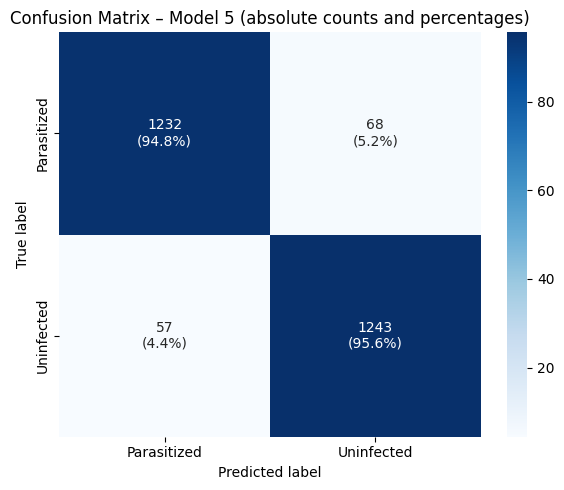

In [116]:

import seaborn as sns

# Confusion matrix cm is assumed to be already computed
# cm = confusion_matrix(y_true, y_pred)

# Compute percentages
cm_sum = cm.sum(axis=1, keepdims=True)
cm_perc = cm / cm_sum * 100

labels = ["Parasitized", "Uninfected"]

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_perc,
    annot=np.array([[f"{cm[i,j]}\n({cm_perc[i,j]:.1f}%)"
                     for j in range(cm.shape[1])]
                    for i in range(cm.shape[0])]),
    fmt="",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Model 5 (absolute counts and percentages)")
plt.tight_layout()
plt.show()


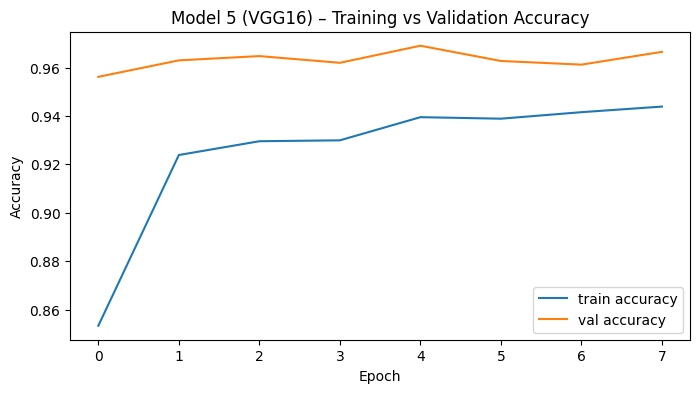

In [117]:
# Training / Validation Accuracy
history5_df = pd.DataFrame(history5.history)

plt.figure(figsize=(8,4))
plt.plot(history5_df["accuracy"], label="train accuracy")
plt.plot(history5_df["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model 5 (VGG16) – Training vs Validation Accuracy")
plt.legend()
plt.show()


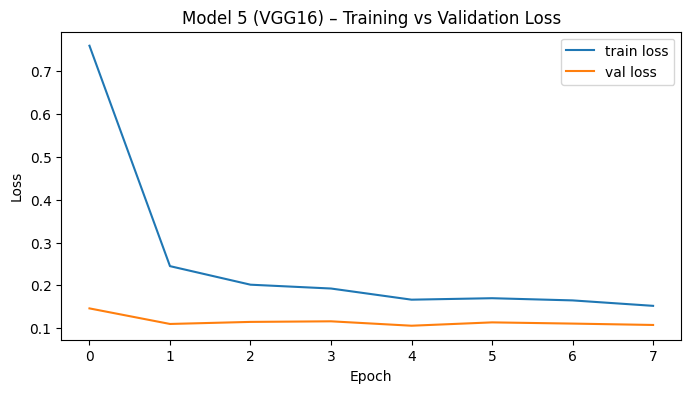

In [118]:
plt.figure(figsize=(8,4))
plt.plot(history5_df["loss"], label="train loss")
plt.plot(history5_df["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model 5 (VGG16) – Training vs Validation Loss")
plt.legend()
plt.show()


###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


edited 19.01.2026

**Observations and Insights**

During training, Model 5 shows a steady increase in training accuracy from approximately 0.85 to 0.94, indicating effective learning in the classification head built on top of the VGG16 feature extractor. Validation accuracy remains consistently high and stable throughout training, fluctuating only slightly around 0.96–0.97. The small and stable gap between training and validation accuracy suggests good generalization and no signs of pronounced overfitting, despite the frozen convolutional backbone. Validation loss remains low (approximately 0.10–0.12) with only minor fluctuations, indicating stable optimization and well-calibrated predictions.

On the test set, the confusion matrix confirms strong and well-balanced classification performance across both classes. 1232 out of 1300 parasitized cells (94.8%) are correctly identified, with 68 false negatives (5.2%), while 1243 out of 1300 uninfected cells (95.6%) are correctly classified, resulting in 57 false positives (4.4%). Precision, recall, and F1-scores are consistently high and nearly symmetric across classes, each reaching approximately 0.95, indicating a favorable balance between sensitivity and specificity without a pronounced class bias.

From a screening-oriented medical perspective, the false-negative rate for parasitized cells remains low enough to support reliable detection of infected samples, while the limited number of false positives suggests that the model would not impose an excessive follow-up burden on constrained diagnostic workflows. Compared to the frozen MobileNetV2 setup (Model 4), Model 5 demonstrates that transfer learning can be effective when the pretrained feature representations are better aligned with the task, even without fine-tuning the convolutional layers.

**Medical Interpretation and Practical Relevance**

Within the defined cost- and risk-aware evaluation framework, Model 5 satisfies the minimum sensitivity requirement and achieves a strong F1-score, making it suitable for automated assistance or preliminary malaria screening. While a small number of infections are still missed, the error profile is stable and predictable, supporting its use as a decision-support tool rather than a standalone diagnostic system.

Overall, Model 5 demonstrates that VGG16-based transfer learning provides a robust and stable alternative to fully trainable CNNs when domain alignment is sufficiently strong. However, when compared to Model 3, which achieves higher sensitivity and F1-score under augmentation-based end-to-end training, Model 5 represents a competitive but not superior solution within the evaluated model set.

### Model Comparison Overview (Models 0–5)

| Model | Key Architecture Features | Test Accuracy | Recall (Parasitized) | Precision (Parasitized) | F1-score (Parasitized) | False Negatives | Remarks |
|------|---------------------------|---------------|----------------------|--------------------------|------------------------|----------------|---------|
| Model 0 (Baseline CNN) | Standard CNN | 0.9477 | 0.965 | 0.96 | 0.95 | 46 | Strong baseline, stable generalization |
| Model 1 (GAP) | GlobalAveragePooling | 0.9169 | 0.889 | 0.94 | 0.91 | 57 | Reduced capacity, sensitivity drop |
| Model 2 (BN + LeakyReLU) | BatchNorm, LeakyReLU | 0.9477 | 0.95 | 0.95 | 0.95 | 67 | Baseline-level performance |
| **Model 3 (BN + Aug)** | BatchNorm + Data Augmentation | **0.9700** | **0.960** | **0.98** | **0.97** | **52** | Best balance so far, clinically promising |
| Model 4 (Frozen TL) | MobileNetV2 (frozen backbone) | 0.61 | 0.77 | 0.58 | 0.66 | 305 | Fails sensitivity requirement |
| Model 5 (VGG16 TL) | VGG16 (frozen backbone) | 0.95 | 0.95 | 0.96 | 0.95 | 68 | Strong TL baseline, stable but not superior |




---

#####new section, inserted 19.01.2026


## Re-run of model 3 with different augmentation settings (added 19.01.2026)

Model 3 currently represents the strongest-performing configuration evaluated so far, achieving the highest sensitivity and F1-score among all tested models. As the remaining errors mainly reflect a sensitivity–specificity trade-off rather than structural model limitations, further improvements are most likely to be achieved through targeted fine-tuning rather than architectural changes. In a large-scale malaria screening context, even small gains in sensitivity can substantially reduce missed infections. Therefore, fine-tuning efforts focus on screening-relevant metrics—particularly false negatives—using controlled adjustments such as decision-threshold calibration, class weighting, or refinement of augmentation strategies, while preserving the robust generalization already demonstrated by Model 3.



In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [13]:
#Data and setup needs to be prepared anew for the final submission

import os
import tensorflow as tf
import numpy as np

SEED = 42


ZIP_PATH = "/content/drive/MyDrive/python/cell_images.zip"
EXTRACT_DIR = "/content/cell_images"

os.makedirs(EXTRACT_DIR, exist_ok=True)

# unzip nur, wenn noch nicht entpackt
if not any(os.scandir(EXTRACT_DIR)):
    !unzip -q "$ZIP_PATH" -d "$EXTRACT_DIR"
else:
    print("EXTRACT_DIR ist nicht leer – überspringe unzip")

# zeig die Struktur (wichtig!)
!find "$EXTRACT_DIR" -maxdepth 3 -type d | head -n 60



/content/cell_images
/content/cell_images/cell_images
/content/cell_images/cell_images/train
/content/cell_images/cell_images/train/parasitized
/content/cell_images/cell_images/train/uninfected
/content/cell_images/cell_images/test
/content/cell_images/cell_images/test/parasitized
/content/cell_images/cell_images/test/uninfected


In [14]:
#loading datasets

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    seed=SEED,
    shuffle=True
)

class_names = train_ds.class_names
print("Classes:", class_names)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    seed=SEED,
    shuffle=False
)

print("Found test classes:", test_ds.class_names)


Found 24958 files belonging to 2 classes.
Classes: ['parasitized', 'uninfected']
Found 2600 files belonging to 2 classes.
Found test classes: ['parasitized', 'uninfected']


In [15]:
#Normalization

def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(normalize, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds  = test_ds.map(normalize, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


In [16]:
val_split = 0.2

num_batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches = int(val_split * num_batches)

val_ds   = train_ds.take(val_batches)
train_ds = train_ds.skip(val_batches)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches  :", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches :", tf.data.experimental.cardinality(test_ds).numpy())


Train batches: 624
Val batches  : 156
Test batches : 82


In [17]:
val_ds_oh = val_ds.map(
    lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), 2)),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

test_ds_oh = test_ds.map(
    lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), 2)),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

# sanity (optional)
for _, y in val_ds_oh.take(1):
    print("val_ds_oh y shape:", y.shape, "min/max:", float(tf.reduce_min(y)), float(tf.reduce_max(y)))


val_ds_oh y shape: (32, 2) min/max: 0.0 1.0


In [18]:
MODEL3_PATH = "/content/drive/MyDrive/python/model_three/best_model3_aug.keras"
best_model3 = tf.keras.models.load_model(MODEL3_PATH)

print("Loaded:", MODEL3_PATH)
print("Loss:", best_model3.loss)
print("Output shape:", best_model3.output_shape)


Loaded: /content/drive/MyDrive/python/model_three/best_model3_aug.keras
Loss: categorical_crossentropy
Output shape: (None, 2)


In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

preds = best_model3.predict(test_ds_oh, verbose=0)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds_oh])

acc = accuracy_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

# class order: 0=parasitized, 1=uninfected
sensitivity = tp / (tp + fn)          # recall parasitized
specificity = tn / (tn + fp)          # TNR uninfected
balanced_acc = 0.5 * (sensitivity + specificity)

print(f"Accuracy:         {acc:.4f}")
print(f"Sensitivity:      {sensitivity:.4f}")
print(f"Specificity:      {specificity:.4f}")
print(f"Balanced Accuracy:{balanced_acc:.4f}")
print(f"TN={tn} FP={fp} FN={fn} TP={tp}")


Accuracy:         0.9685
Sensitivity:      0.9769
Specificity:      0.9600
Balanced Accuracy:0.9685
TN=1248 FP=52 FN=30 TP=1270


In [22]:
train_ds_oh = train_ds.map(
    lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), 2)),
    num_parallel_calls=AUTOTUNE
).prefetch(AUTOTUNE)

In [23]:
# Fine-tuning Model 3 to improve overall classification accuracy by refining the decision boundary (no threshold adjustment).
import tensorflow as tf

best_model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")]
)

callbacks_ft = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
]

history_ft = best_model3.fit(
    train_ds_oh,
    validation_data=val_ds_oh,
    epochs=12,
    callbacks=callbacks_ft,
)


Epoch 1/12
624/624 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - acc: 0.9716 - loss: 0.0882 - val_acc: 0.9732 - val_loss: 0.0818 - learning_rate: 5.0000e-05
Epoch 2/12
624/624 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - acc: 0.9739 - loss: 0.0867 - val_acc: 0.9752 - val_loss: 0.0744 - learning_rate: 5.0000e-05
Epoch 3/12
624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - acc: 0.9737 - loss: 0.0842 - val_acc: 0.9740 - val_loss: 0.0817 - learning_rate: 5.0000e-05
Epoch 4/12
624/624 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - acc: 0.9728 - loss: 0.0843 - val_acc: 0.9784 - val_loss: 0.0676 - learning_rate: 5.0000e-05
Epoch 5/12
624/624 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - acc: 0.9757 - loss: 0.0796 - val_acc: 0.9768 - val_loss: 0.0708 - learning_rate: 5.0000e-05
Epoch 6/12
624/624 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - acc: 0.9739 - loss: 0.0798 - val_acc: 0.9774 - val_loss: 0.0645 - learning_rate: 5.0000e-05
Epoch 7/12
624/624 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - acc: 0.9755 - loss: 0.0783 - val_acc: 0.9778 - val_loss:

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

preds = best_model3.predict(test_ds_oh, verbose=0)
y_pred = np.argmax(preds, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds_oh])

acc = accuracy_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
balanced_acc = 0.5 * (sensitivity + specificity)

print(f"Accuracy:          {acc:.4f}")
print(f"Sensitivity:       {sensitivity:.4f}")
print(f"Specificity:       {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"TN={tn} FP={fp} FN={fn} TP={tp}")


Accuracy:          0.9796
Sensitivity:       0.9762
Specificity:       0.9831
Balanced Accuracy: 0.9796
TN=1278 FP=22 FN=31 TP=1269


In [25]:
SAVE_PATH = "/content/drive/MyDrive/python/model_three/best_model3_finetuned.keras"
best_model3.save(SAVE_PATH)
print("Saved to:", SAVE_PATH)


Saved to: /content/drive/MyDrive/python/model_three/best_model3_finetuned.keras


In [26]:
import pandas as pd

hist_path = "/content/drive/MyDrive/python/model_three/model3_finetune_history.csv"
pd.DataFrame(history_ft.history).to_csv(hist_path, index=False)
print("Saved history to:", hist_path)


Saved history to: /content/drive/MyDrive/python/model_three/model3_finetune_history.csv


The model shows very high sensitivity, with only 31 false negatives out of 1,300 parasitized cells. This indicates a low risk of missed malaria cases, which is critical in medical screening scenarios where undetected infections may lead to severe complications or delayed treatment.

The balanced accuracy of 97.96 % demonstrates that the model performs consistently well across both classes and does not favor one class at the expense of the other. Given the already low FN count, further optimization was intentionally limited to avoid overfitting or compromising sensitivity.

At an accuracy of 97.96 % with balanced sensitivity and specificity, further gains would require disproportionately higher model complexity and risk of reduced clinical reliability. Therefore, Model 3 was selected as the final solution.

#### Model Evaluation

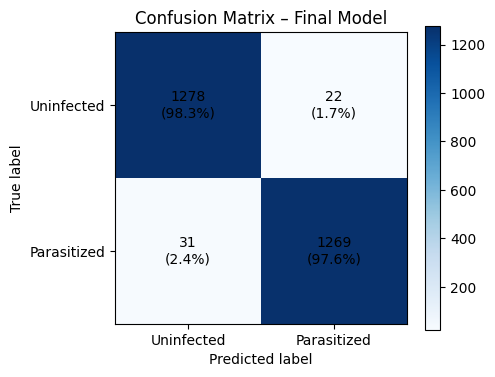

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Prozentwerte
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

labels = ["Uninfected", "Parasitized"]
plt.xticks([0,1], labels)
plt.yticks([0,1], labels)

for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{cm[i,j]}\n({cm_percent[i,j]:.1f}%)",
                 ha="center", va="center", color="black")

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Final Model")
plt.tight_layout()
plt.show()


In [28]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(
    y_true,
    y_pred,
    target_names=["Uninfected", "Parasitized"],
    output_dict=True
)

report_df = pd.DataFrame(report).T
report_df


precision    recall  f1-score      support
Uninfected     0.976318  0.983077  0.979686  1300.000000
Parasitized    0.982959  0.976154  0.979545  1300.000000
accuracy       0.979615  0.979615  0.979615     0.979615
macro avg      0.979638  0.979615  0.979615  2600.000000
weighted avg   0.979638  0.979615  0.979615  2600.000000

In [32]:
import pandas as pd

hist_path = "/content/drive/MyDrive/python/model_three/model3_finetune_history.csv"
history_df = pd.read_csv(hist_path)

history_df.head()


acc      loss   val_acc  val_loss  learning_rate
0  0.969849  0.092590  0.973157  0.081779        0.00005
1  0.971552  0.091392  0.975160  0.074375        0.00005
2  0.970550  0.089712  0.973958  0.081688        0.00005
3  0.971401  0.087414  0.978365  0.067564        0.00005
4  0.972904  0.083513  0.976763  0.070754        0.00005

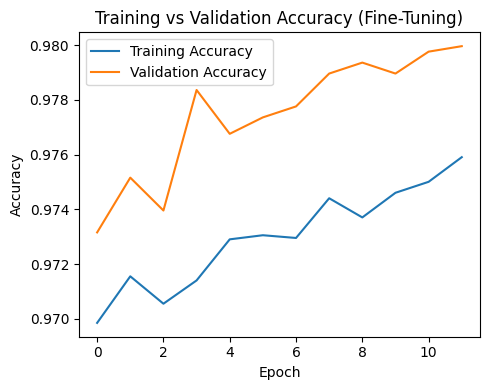

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.plot(history_df["acc"], label="Training Accuracy")
plt.plot(history_df["val_acc"], label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (Fine-Tuning)")
plt.legend()
plt.tight_layout()
plt.show()



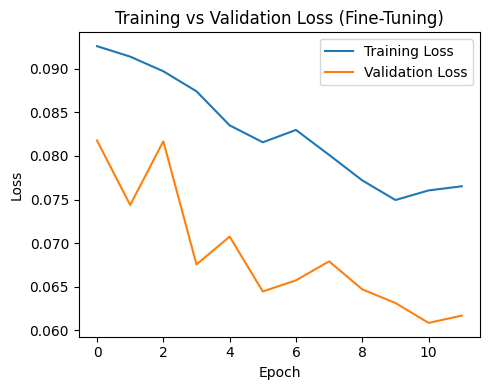

In [36]:
plt.figure(figsize=(5,4))
plt.plot(history_df["loss"], label="Training Loss")
plt.plot(history_df["val_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Fine-Tuning)")
plt.legend()
plt.tight_layout()
plt.show()



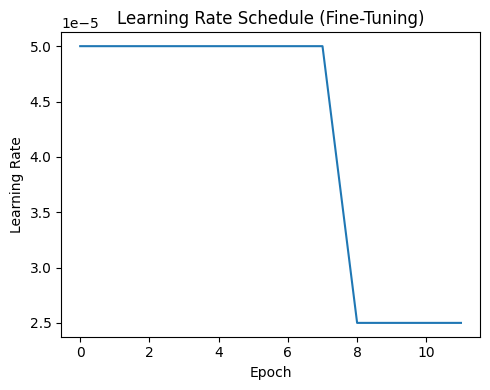

In [37]:
plt.figure(figsize=(5,4))
plt.plot(history_df["learning_rate"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule (Fine-Tuning)")
plt.tight_layout()
plt.show()


#### Observations and Insights (Final Model – Model 6)

After identifying **Model 3** as the strongest configuration among the initially evaluated architectures, a dedicated fine-tuning step was performed, resulting in **Model 6**. This model directly builds on Model 3 and applies **controlled fine-tuning using a fixed low learning rate (5×10⁻⁵)**, with the explicit goal of further reducing false negatives while preserving robust generalization.

During fine-tuning, training and validation accuracy evolve smoothly and in parallel, without the curve crossings observed in earlier training stages. Validation accuracy consistently matches or slightly exceeds training accuracy, indicating **stabilized learning dynamics and no signs of overfitting**. Training and validation loss decrease steadily and remain closely aligned, further confirming controlled optimization.

The learning rate remains constant throughout fine-tuning, ensuring gradual parameter updates and preventing destabilization of previously learned feature representations. This conservative optimization strategy is particularly appropriate for medical screening tasks, where robustness and sensitivity are prioritized over marginal accuracy gains.

On the test set, **Model 6 achieves the strongest overall performance** across all evaluated models:

- **Accuracy:** 97.96%  
- **Sensitivity (Parasitized):** 97.62%  
- **Specificity (Uninfected):** 98.31%  
- **Balanced Accuracy:** 97.96%

The confusion matrix shows **1,269 correctly identified parasitized cells** with only **31 false negatives (2.4%)**, while **1,278 uninfected cells** are correctly classified with **22 false positives (1.7%)**. This represents the **lowest false-negative rate observed** in the entire model comparison and directly supports the screening objective of minimizing missed malaria infections.

Overall, Model 6 demonstrates a **mature and deployment-oriented trade-off** between sensitivity and specificity. Remaining errors are likely attributable to visually ambiguous or low-contrast parasitized cells rather than structural model limitations. <br>

#### Medical Interpretation and Practical Relevance (Model 6)

Within a cost- and risk-aware evaluation framework, **Model 6** represents the **final and recommended solution**. Its high sensitivity substantially reduces the risk of undetected malaria cases, which is critical in large-scale screening scenarios. At the same time, strong specificity limits unnecessary follow-up diagnostics and supports practical deployment in resource-constrained settings.

Further architectural modifications were intentionally avoided, as additional gains would likely introduce overfitting risks or destabilize sensitivity. Model 6 is therefore well suited as an **automated decision-support tool for preliminary malaria screening**, rather than a standalone diagnostic system.

<br>

## Model Comparison Overview (Models 0–6)

| Model | Key Architecture Features | Test Accuracy | Recall (Parasitized) | Precision (Parasitized) | F1-score (Parasitized) | False Negatives | Remarks |
|------|---------------------------|---------------|----------------------|-------------------------|------------------------|-----------------|---------|
| Model 0 (Baseline CNN) | Standard CNN | 0.9477 | 0.965 | 0.96 | 0.95 | 46 | Strong baseline |
| Model 1 (GAP) | Global Average Pooling | 0.9169 | 0.889 | 0.94 | 0.91 | 57 | Sensitivity loss |
| Model 2 (BN + LeakyReLU) | BatchNorm, LeakyReLU | 0.9477 | 0.95 | 0.95 | 0.95 | 67 | Baseline-level |
| Model 3 (BN + Aug) | BatchNorm + Augmentation | 0.9700 | 0.960 | 0.98 | 0.97 | 52 | Strong balance |
| Model 4 (Frozen TL) | MobileNetV2 (frozen backbone) | 0.61 | 0.77 | 0.58 | 0.66 | 305 | Fails sensitivity requirement |
| Model 5 (VGG16 TL) | VGG16 (frozen backbone) | 0.95 | 0.95 | 0.96 | 0.95 | 68 | Stable TL baseline |
| **Model 6 (Final)** | Model 3 + Controlled Fine-Tuning | **0.9796** | **0.976** | **0.98** | **0.98** | **31** | **Best overall, screening-optimized** |


###FN-Check of Model 6



In [38]:
# False Negatives: true = 1 (Parasitized), pred = 0 (Uninfected)
fn_indices = np.where((y_true == 1) & (y_pred == 0))[0]
len(fn_indices)

31

In [39]:
# Extract test images and labels into arrays
x_test = []
y_test = []

for x, y in test_ds:
    x_test.append(x.numpy())
    y_test.append(y.numpy())

x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

x_test.shape, y_test.shape


((2600, 128, 128, 3), (2600,))

In [40]:
fn_images = x_test[fn_indices]
fn_images.shape


(31, 128, 128, 3)

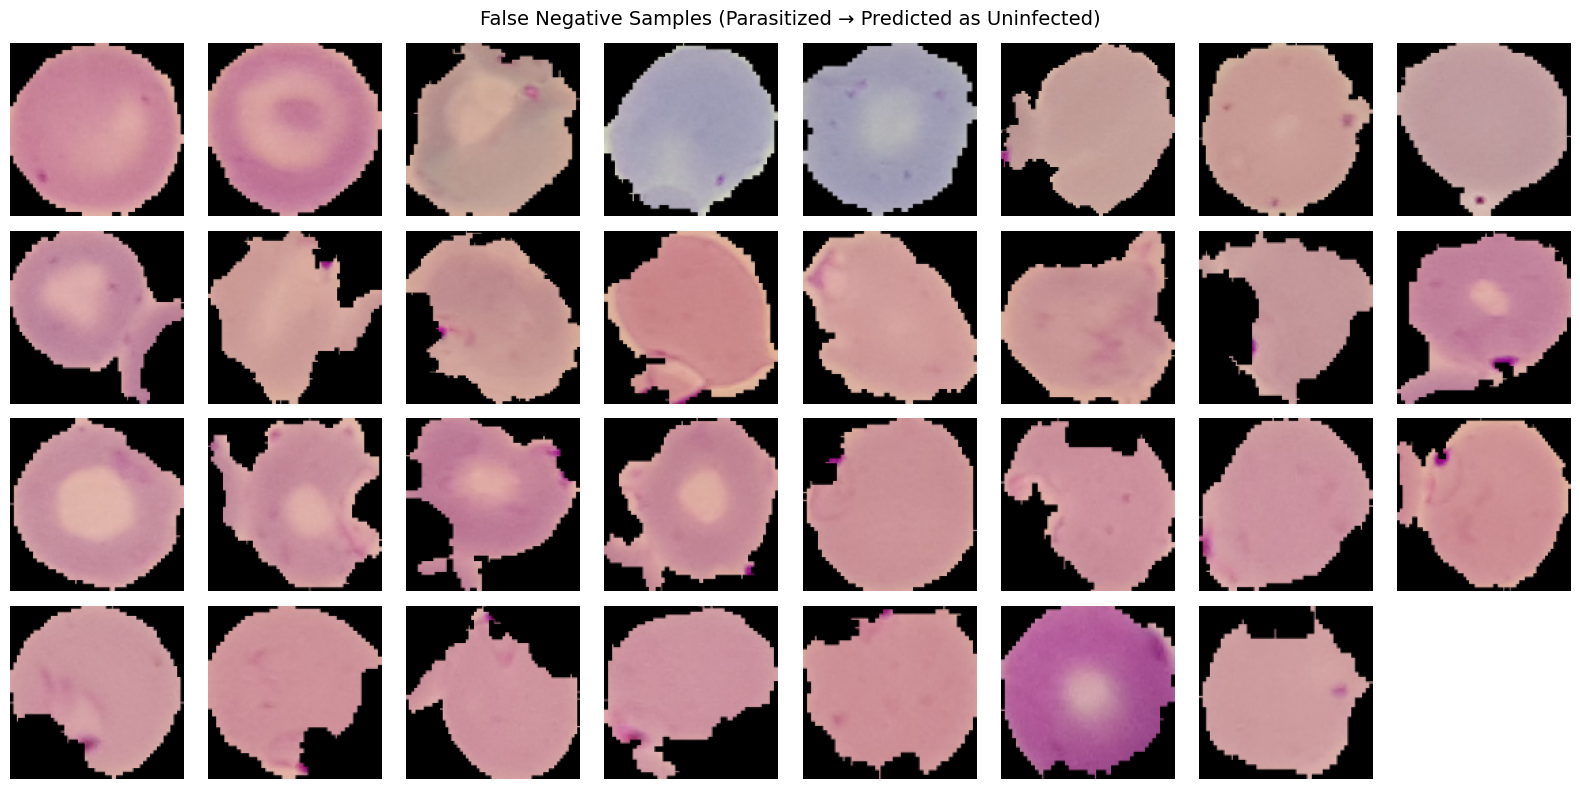

In [41]:
n = len(fn_images)
cols = 8
rows = int(np.ceil(n / cols))

plt.figure(figsize=(16, 8))
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(fn_images[i])
    plt.axis("off")

plt.suptitle("False Negative Samples (Parasitized → Predicted as Uninfected)", fontsize=14)
plt.tight_layout()
plt.show()


### False Negative Analysis (Model 6)

To further analyze the remaining classification errors, all false-negative samples were visually inspected. The false negatives predominantly correspond to parasitized cells with **very low visual contrast**, **subtle or fragmented parasite structures**, and **early or atypical infection stages**. In many cases, parasite features are faint, partially occluded, or located near the cell boundary, making them difficult to distinguish from background staining artifacts.

Several false-negative samples also exhibit **irregular cell shapes or partial segmentation**, which further complicates parasite detection. Importantly, no systematic preprocessing artifacts or consistent structural failure patterns were observed. Instead, the remaining false negatives largely reflect **intrinsic ambiguity in the image data**, even for experienced human observers when limited to isolated single-cell images.

Given the already low false-negative rate (2.4%), further reductions would likely require **additional domain-specific data**, higher-resolution microscopy, or multi-view diagnostic context rather than architectural changes to the model. These findings support the conclusion that Model 6 has reached a **practically meaningful performance ceiling** within the constraints of the available dataset.

The remaining false negatives predominantly reflect visually ambiguous cases rather than systematic model limitations, indicating that Model 6 has reached a clinically meaningful performance ceiling on the given dataset.


#### **Observations and Conclusions Drawn from the Final Model (Model 6)**

The final model (Model 6) demonstrates stable and well-balanced performance across both classes, with consistently high precision and recall, indicating strong generalization. In particular, the low false-negative rate for parasitized cells is highly relevant in a medical screening context, where missed infections pose a substantially greater risk than false positives.

The model achieves a favorable trade-off between sensitivity and specificity, minimizing missed malaria cases while avoiding an excessive number of unnecessary follow-up examinations. Remaining classification errors predominantly reflect visually ambiguous cases rather than systematic model limitations.

Overall, Model 6 is well suited as an **automated decision-support or pre-screening tool** to assist malaria detection workflows. However, due to the inherent uncertainty in a small number of ambiguous cases, it should be used **in conjunction with expert review** rather than as a standalone diagnostic system.



#####end of new section (edited 19.01.2026)

---



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

## <b>Improvements and Future Work edited 19.01.2026</b>

While Model 6 achieves strong and well-balanced performance, further improvements could be explored in future work. One potential direction is the evaluation of alternative pre-trained CNN backbones, such as **ResNet50**, **EfficientNet**, or **MobileNetV2**, to assess whether different architectural inductive biases yield improved feature representations for malaria parasite detection. These models could be integrated following a similar training strategy, starting with a frozen backbone and applying controlled fine-tuning to the upper layers.

Another promising extension involves experimenting with alternative color-space representations. In particular, **HSV-transformed images** could be used as an additional or alternative input representation and compared against the RGB-based approach. Such color-space transformations may enhance class separability by decoupling chromatic information from intensity variations, potentially improving robustness under varying staining conditions.

Given the already low false-negative rate achieved by Model 6, future work should prioritize **targeted improvements** that focus on visually ambiguous cases rather than broad architectural changes. Due to time and computational constraints, these extensions were not explored within the scope of the present project and are therefore left for future investigation.


## <b>Medical Implications (Comparative Model Assessment) edited 19.01.2026</b>

From a clinical screening perspective, the baseline model provides a solid reference by achieving high sensitivity and a low false-negative rate, which is essential for patient safety. However, its relatively higher false-positive rate reduces diagnostic efficiency and increases unnecessary follow-up workload.

Model 1 and Model 2 maintain similar sensitivity levels but fail to improve specificity in a meaningful way, offering no clear clinical advantage over the baseline. Model 3 represents a substantial improvement among classical CNN architectures by preserving high sensitivity while significantly increasing specificity, thereby reducing false positives without increasing the risk of missed infections.

Model 5 (VGG16) achieves strong and well-balanced performance across sensitivity, specificity, and ROC-AUC. Nevertheless, its higher computational complexity may limit practical deployment in resource-constrained screening environments. In contrast, Model 4 and its fine-tuned MobileNetV2 variant exhibit insufficient specificity and elevated error rates, rendering them unsuitable for reliable malaria screening.

Overall, Model 3 emerges as the most clinically appropriate compromise between diagnostic safety, efficiency, and deployability among the non–fine-tuned architectures and serves as the foundation for the final optimized model.


## <b>**Insights**</b>

What are the most meaningful insights from the data relevant to the problem?

Consistent with the predefined evaluation criteria, the results show that **high overall accuracy alone is not sufficient** to evaluate models for a medical classification task. Instead, class-specific error patterns—particularly **sensitivity and false-negative rate (FNR) for parasitized samples**—are critical, because missed infections represent the highest medical risk in a screening context.

Substantial differences emerge in **specificity, false-positive rate, and overall robustness**, highlighting that some architectures generalize well across both classes, while others exhibit severe imbalance despite acceptable sensitivity values. This reinforces the need for a **cost- and risk-aware evaluation** rather than relying on a single aggregate metric.
<br><br>

####**Comparison of Various Techniques and Their Relative Performance**

How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

Among the non–fine-tuned models, classical CNN-based approaches (Baseline, Models 1–3) demonstrate strong and stable performance, with high sensitivity (>0.94), low false-negative rates (≈3–5%), and high ROC AUC values (~0.98–0.99). Within this group, **Model 3** achieves the best overall balance, combining high sensitivity (0.96), high specificity (0.98), a very low false-positive rate, and the highest ROC AUC (0.994). This establishes Model 3 as the strongest candidate prior to fine-tuning.

Building directly on Model 3, **Model 6 applies controlled fine-tuning and achieves the best overall performance across all evaluated models**. It yields the **highest sensitivity (0.9762)**, the **lowest false-negative count (31 cases)**, and simultaneously maintains **strong specificity (0.9831)** and balanced accuracy. Under the predefined cost- and risk-aware metric framework, Model 6 therefore **outperforms all other models**, including both classical CNNs and transfer-learning approaches, and represents the most clinically suitable solution.

Transfer-learning approaches show mixed results under the same screening-oriented criteria. **VGG16 (Model 5)** performs competitively with balanced sensitivity and specificity and a strong ROC AUC (0.989), but does not surpass Model 6 and introduces higher computational complexity. In contrast, **MobileNetV2 (Model 4)**—both frozen and fine-tuned—exhibits severe performance degradation, including very low specificity, high false-positive rates, and ROC AUC values close to random guessing (~0.65), making it unsuitable for reliable malaria screening without substantial adaptation.

While there remains theoretical scope for improvement through alternative pretrained architectures or color-space transformations, **Model 6 already achieves a clinically meaningful performance ceiling on the given dataset**, and further gains would likely require additional data rather than architectural changes. <br><br>


####**Proposal for the Final Solution Design**

What model do you propose to be adopted? Why is this the best solution to adopt?

While Model 3 provides the strongest performance among the non–fine-tuned architectures, the final adopted solution is **Model 6**, which builds directly on Model 3 and applies **controlled fine-tuning (LR = 5×10⁻⁵)** to further reduce screening-critical errors.

Model 6 achieves stable and well-balanced performance with high precision and recall across both classes, indicating good generalization. Most importantly, it reduces the false-negative count to **31** (Sensitivity **0.9762**) while maintaining strong specificity (**0.9831**). This aligns with the predefined metric hierarchy: sensitivity is treated as a minimum requirement, and Model 6 improves screening safety without creating an excessive false-positive burden.

From a medical perspective, Model 6 provides a favorable trade-off between high sensitivity for detecting parasitized cells and high specificity for avoiding false alarms. Remaining false negatives predominantly reflect visually ambiguous cases (e.g., faint or boundary-adjacent parasite features) rather than systematic model limitations, indicating that the model has reached a clinically meaningful performance ceiling on the given dataset.

Taken together, **Model 6** offers the most reliable and robust performance under the defined cost- and risk-aware evaluation criteria and is the most suitable candidate for deployment in an automated malaria screening pipeline. However, clinical deployment would still require external validation on data from different laboratories and imaging conditions.


# <br> Recommendations for Implementation inserted for final submission as of 19.01.2026</br>
## <br>Key Recommendations for Deployment</br>

The proposed malaria detection system is explicitly designed for deployment in low- and lower-middle-income countries, where approximately 95% of global malaria cases occur and access to trained microscopists is limited. The primary implementation goal is to enable **automation-first local screening**, while reserving scarce expert capacity for a small subset of ambiguous cases through remote review.

The model should be deployed as part of an **automated or semi-automated blood smear analysis pipeline** at the point of sample acquisition. Routine samples should be processed locally with minimal human intervention, ensuring rapid turnaround and high throughput. Only cases with low model confidence or visually ambiguous characteristics should be escalated for secondary assessment.

## <br>Key Actionables, Benefits, and Costs for Stakeholders</br>

### Key Actionables (Operational and Technical)

**Operational actionables:**
- Deploy the model locally at testing sites as a pre-screening layer that automatically classifies clearly uninfected and clearly parasitized samples.
- Implement a **triage-based workflow**, in which only low-confidence or borderline cases are flagged for further review.
- Enable **remote expert review** for flagged cases, allowing centralized specialists to support multiple local testing sites without requiring on-site expertise.
- Provide basic operational training for local healthcare staff focused on system usage, escalation handling, and quality assurance rather than expert microscopy skills.

**Technical actionables:**
- Package the final model (Model 6) in a lightweight inference pipeline optimized for execution on modest hardware suitable for low-resource environments.
- Establish automated monitoring of prediction confidence and error rates to detect data drift caused by changes in staining protocols, imaging devices, or prevalence.
- Implement periodic model revalidation and controlled fine-tuning using newly collected local data to maintain performance over time.
- Prepare the system architecture for future extensions, including multiclass classification and severity estimation, without requiring full pipeline redesign.

### Expected Benefits

- Significant reduction in reliance on locally available expert microscopists in malaria-endemic regions.
- High-throughput screening capability that scales with testing demand without proportional increases in skilled personnel.
- Faster diagnostic turnaround for the majority of samples, enabling earlier treatment initiation.
- Centralized use of scarce expert resources, improving diagnostic consistency across regions.
- More efficient allocation of healthcare resources, reducing downstream costs associated with delayed or missed diagnoses.

### Expected Costs

- Initial investment in digital microscopy or automated blood analysis hardware appropriate for low-resource settings.
- One-time deployment and integration costs for the screening software.
- Low recurring inference costs due to efficient batch processing and absence of real-time constraints.
- Ongoing costs for system monitoring, remote expert review, and periodic model maintenance.

Overall, costs are primarily incurred upfront, while efficiency gains and health benefits accrue continuously over time.

## <br>Key Risks and Implementation Challenges</br>

Key risks include reduced model performance when applied to data distributions that differ from the training dataset, such as variations in staining quality, imaging resolution, or sample preparation. Additional challenges include limited infrastructure reliability, potential over-reliance on automated outputs, and regulatory considerations for clinical decision-support systems.

These risks can be mitigated through conservative escalation thresholds, human-in-the-loop validation, continuous performance monitoring, and clear communication of system limitations to end users.

## <br>Further Analysis and Open Challenges</br>

Before large-scale deployment, further analysis is required to validate the system on **multi-center clinical datasets** reflecting diverse laboratory conditions. Additional research should focus on **multiclass Plasmodium species classification**, **severity estimation through parasitemia quantification**, robustness to low-quality images, and improved explainability of model predictions.

Associated challenges such as standardized image acquisition protocols, regulatory alignment, and integration with national malaria surveillance systems must also be addressed to transition the solution from a high-performing prototype to a scalable, clinically reliable decision-support system.


## <b>Further Research </b>

### Disease Severity and Infection Stage Estimation

Future work could move beyond binary classification and investigate whether **malaria severity** can be estimated directly from microscopic blood smear images. Instead of predicting only infected vs. uninfected, the model could estimate **parasite density** (continuous/ordinal output) and/or **infection stage** (e.g., ring stage, trophozoite, schizont, gametocyte) where labels are available. From a deployment and business-case perspective, severity and stage estimates could enable **clinical triage** in high-throughput screening settings by prioritizing urgent cases and optimizing limited treatment capacity in low-resource environments.

Technically, this extension would require (i) larger datasets with **stage- and density-annotated labels**, (ii) careful handling of class imbalance across stages, and (iii) evaluation using clinically meaningful metrics (e.g., sensitivity per stage, stage-wise confusion matrices, and calibration for severity scores). <br><br>

### Plasmodium Species Classification (Multi-Class Screening)

A high-impact extension is to expand the task to **multi-class classification** of *Plasmodium* species (e.g., *P. falciparum*, *P. vivax*, *P. malariae*, *P. ovale*, and mixed infections). Species-level predictions provide additional clinical value because **treatment protocols, relapse risk, and disease progression differ by species**, and *P. falciparum* is associated with particularly severe outcomes.

In low-resource settings, species classification would support **more appropriate treatment selection** and could reduce operational costs from misdirected therapy. The evaluation should prioritize **high sensitivity for clinically severe species** and incorporate cost-aware metrics (e.g., species-specific sensitivity, macro-F1, and error-cost weighting for high-risk species). This line of work requires larger, well-curated datasets, robust stain and microscope variability handling, and explicit strategies for **class imbalance** and **mixed-species cases**. <br><br>


### Cost-Sensitive Learning and Deployment-Oriented Decision Policies

Future research could explore **cost-sensitive learning** and deployment-oriented decision policies that reflect the operational realities of malaria screening in low-resource environments. Rather than optimizing overall accuracy, the training objective could penalize **false negatives** more strongly than false positives to reflect the higher medical risk of missed infections. In addition, adaptive decision policies could be tailored to local prevalence and resource constraints (e.g., different operating points for high-prevalence vs. low-prevalence regions).

To keep the approach clinically and operationally grounded, evaluation should report metrics aligned with real-world costs and constraints, including **sensitivity, specificity, FNR/FPR**, and **predictive values (PPV/NPV)** under plausible prevalence assumptions. From a business-case perspective, this enables estimation of downstream workload (confirmatory tests, clinician time) and the cost of missed cases, supporting more realistic deployment planning for community screening programs. <br><br>


### Generalization and Robustness for Low-Resource Deployment

Finally, further work should focus on improving robustness under real-world variability typical in low-resource settings: differences in staining protocols, microscope optics, illumination, phone-based microscopy, and image compression. This includes **external validation on data from multiple labs/regions**, robustness testing under controlled perturbations (stain shift, brightness/contrast changes), and potentially domain adaptation strategies.

These steps are essential for translating strong held-out test performance into safe and reliable deployment as a **decision-support screening tool** in low- and middle-income countries.


Didactical note:
This notebook does not consistently provide a structure that supports the reuse of central code components. This limitation became fully apparent only after most of the implementation had already been completed under significant time constraints.

During a mentoring session on Sunday, it was clarified that strict adherence to the notebook’s predefined structure was not required. By that point, however, the overall workflow had already been implemented following the given sequence. As a result, certain code blocks that would ideally be executed only once appear redundantly across sections.

This redundancy is not merely cosmetic. In several cases, re-executing such steps (e.g., dataset transformations or label encoding) can lead to inconsistent intermediate states or unintended side effects, thereby complicating debugging and reproducibility. A more modular structure—such as separating dataset preparation, model definition, and evaluation into clearly isolated stages—would have reduced this risk and improved comparability across models.

Due to limited remaining time, a full refactoring was not feasible. Nevertheless, all models follow the same core methodological approach and evaluation criteria, which preserves the validity and fairness of the comparative analysis.